# Homework 3
In this homework, we will explore language generation using character-level RNNs. Sounds awesome, right?

A few notes at the beginning:
- It might be useful for you to read the whole assignment before beginning. Especially the last two sections so you know what to record for turning in.
- Much of the required knowledge in this (and past) homeworks about Python, PyTorch, etc. are not explained fully here. Instead, we expect you to use the existing documentation, search engines, Stack Overflow, etc. for implementation details.
- That being said, we have listed several functions in parts of the homework where knowing those functions exist would be especially useful. However you will still need to read the docs on how to specifically use the functions.

# Part 0: Initial setup
You should recognize this code from last time.


In [1]:
import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())
  
# Running this should then print out:
# Version 1.3.0+cu100
# CUDA enabled: True

Version 1.3.1+cu100
CUDA enabled: True


In [2]:
from google.colab import drive
drive.mount('/gdrive')
!ls 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
sample_data


# Part 1: Upload the dataset
We will be using the complete text of Harry Potter as our corpus. We will provide it for you in a not-very-well-formatted way.
Run this code to set up the homework3 files.



In [3]:
import os
BASE_PATH = '/gdrive/My Drive/colab_files/homework3/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = '/content/'

if not os.path.exists(os.path.join(DATA_PATH, 'harry_potter.txt')):
    os.chdir(BASE_PATH)
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
    !tar -zxvf homework3.tar.gz
    !rm homework3.tar.gz
    !cp pt_util.py /content
    !cp harry_potter.txt /content
os.chdir('/content')
!ls

--2019-11-17 09:46:52--  https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
Resolving courses.cs.washington.edu (courses.cs.washington.edu)... 128.208.1.193, 2607:4000:200:10::c1
Connecting to courses.cs.washington.edu (courses.cs.washington.edu)|128.208.1.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2324076 (2.2M) [application/x-gzip]
Saving to: ‘homework3.tar.gz’

homework3.tar.gz    100%[===================>]   2.22M  2.24MB/s    in 1.0s    

2019-11-17 09:46:54 (2.24 MB/s) - ‘homework3.tar.gz’ saved [2324076/2324076]

harry_potter.txt
pt_util.py
harry_potter.txt  pt_util.py  sample_data


In [0]:
!rm doupo.txt
!ls

rm: cannot remove 'doupo.txt': No such file or directory
checkpoints		      harry_potter.txt	__pycache__
harry_potter_chars_test.pkl   logs		sample_data
harry_potter_chars_train.pkl  pt_util.py


In [0]:
if not os.path.exists(os.path.join(DATA_PATH, 'doupo.txt')):
    os.chdir(BASE_PATH)
    !cp doupo.txt /content
os.chdir('/content')
!ls

checkpoints		     harry_potter_chars_train.pkl  pt_util.py
doupo.txt		     harry_potter.txt		   __pycache__
harry_potter_chars_test.pkl  logs			   sample_data


In [0]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import re
import pt_util
import math

#Part 2: Preprocessing the data
In previous homeworks, we have provided a cleaned version of the data. But this time you'll have to do some of that cleaning yourselves.

Hints:
- train_text and test_text should contain the class indices for the character tokens from the data file. For example, if the text was **`"ABA CDBE"`**, the token version would be a numpy array with contents `[0, 1, 0, 2, 3, 4, 1, 5]`
- The harry_potter.txt file has weird spacing. You might want to replace all the whitespace characters (space, \n, \t, etc.) in the file with the space character.
- You should output two files. One for training and one for testing. The training should be the first 80% of the characters.
- voc2ind is a map from character to the index of the class for that character. There is no predefined vocabulary, but you will need to be consistent across all tasks that use the vocabulary. For the example above, the voc2ind would be `{'A': 0, 'B': 1, ' ': 2, 'C': 3, 'D': 4, 'E': 5}`
- ind2voc is the inverse of voc2ind



In [0]:
with open(DATA_PATH + 'doupo.txt','r',encoding='utf-8') as f:
    data = f.read()
print(len(data))
data=data[:10]
print(data)
print("-----------------")
data_split = data.split()
print(data_split)
print("-----------------")
data = ' '.join(data_split)
data = data.replace('\n', ' ').replace('\t', ' ')
print(data)

5562048
   三十年河东，三
-----------------
['三十年河东，三']
-----------------
三十年河东，三


In [0]:
with open(DATA_PATH + 'harry_potter.txt') as f:
    data = f.read()

data=data[:3]
print(data)
print("-----------------")
data_split = data.split()
print(data_split)
print("-----------------")
data = ' '.join(data_split)
data = data.replace('\n', ' ').replace('\t', ' ')
print(data)

Har
-----------------
['Har']
-----------------
Har


In [0]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    '''
    data_split = data.split()
    data = ' '.join(data_split)
    data = data.replace('\n', ' ').replace('\t', ' ')
    voc2ind = {}
    '''
    voc2ind = {}
    data = re.sub('\s+', ' ', data)
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    count=0
    data_arr = [0]*len(data)
    for num, char in enumerate(data):
         # TODO Fill this in
        if char not in voc2ind:
            voc2ind[char]=count
            count+=1
        data_arr[num]=voc2ind[char]


    ind2voc = {val: key for key, val in voc2ind.items()}

    train_len = round(len(data_arr)*4/5)
    train_text = data_arr[:train_len] # TODO Fill this in
    test_text = data_arr[train_len:] # TODO Fill this in
    # print(voc2ind)

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_test.pkl', 'wb'))
########change file name################################################    
prepare_data(DATA_PATH + 'harry_potter.txt')

class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

In [0]:
!ls

checkpoints		     harry_potter_chars_train.pkl  pt_util.py
doupo.txt		     harry_potter.txt		   __pycache__
harry_potter_chars_test.pkl  logs			   sample_data


#Part 3: Loading the data
This is possibly the trickiest part of this homework. In the past, batches were not correlated with each other, and the data within a single minibatch was also not correlated, so you could basically draw randomly from the dataset. That is not the case here. Instead, you should return sequences from the dataset.

Your instructions are to implement the following. First, imagine splitting the dataset into N chunks where N is the batch_size and the chunks are contiguous parts of the data. For each batch, you should return one sequence from each of the chunks. The batches should also be sequential an example is described below.

The data is 20 characters long `[1, 2, 3, ...20]`. The batch size is `2` and the sequence length is `4`
- The 1st batch should consist of  `(data =  [[1, 2, 3, 4]; [11, 12, 13, 14]], labels = [[2, 3, 4, 5]; [12, 13, 14, 15]])`
- The 2nd batch should consist of `(data =  [[5, 6, 7, 8]; [15, 16, 17, 18]], labels = [[6, 7, 8, 9]; [16, 17, 18, 19]])`
- The 3rd batch should consist of `(data =  [[9]; [19]], labels = [[10]; [20]])`
- There is no 4th batch.

Hints:
- To work with the rest of the code, your len(dataset) should be a multiple of the batch_size. 
- Removing the last bit to make the data the proper shape will probably give better results than padding with 0s.
- It is OK to have one batch be shorter than the others as long as all entries in that batch are the same length.
- Notice that the last label in one batch is the first data in the next batch. Be careful of off-by-one errors.



In [0]:
class HarryPotterDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        # TODO: Any preprocessing on the data to get it to the right shape.
        data = dataset['tokens']
        # for 2 batch, we divide the data to 2 chunk
        chunk_num = int(len(data)/self.batch_size)
        self.data = data[:chunk_num*self.batch_size]
        self.len= (int((chunk_num-2)/sequence_length)+1)*batch_size
        self.chunk_num=chunk_num
        # the sequence length of the last batch
        self.lastSeqLen=int(chunk_num%sequence_length-1)
        # print("the sequence length of last batch is", self.lastSeqLen)
        # print("how many batches the data have",self.len/batch_size)

    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters.m
        return self.len
         # raise NotImplementedError 
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        if idx>=self.len:
          return None
        batch_size=self.batch_size
        chunk_num=self.chunk_num
        batch_idx = int(idx/batch_size)
        chunk_idx = idx%batch_size
        # print(batch_idx)
        # print(chunk_idx)
        if batch_idx==self.len/batch_size-1:
          data_idx = int(chunk_idx*chunk_num+batch_idx*self.sequence_length)
          data = self.data[data_idx:data_idx+self.lastSeqLen]
          label = self.data[data_idx+1:data_idx+self.lastSeqLen+1]
        else:
          data_idx = int(chunk_idx*chunk_num+batch_idx*self.lastSeqLen)
          data = self.data[data_idx:data_idx+self.sequence_length]
          label = self.data[data_idx+1:data_idx+self.sequence_length+1]
        data = torch.Tensor(data).long()
        label = torch.Tensor(label).long()
        return data, label

    def vocab_size(self):
        return len(self.vocab)

# Part 4: Defining the Network
This time we will provide a network that should already get pretty good performance. You will still need to write the forward pass and inference functions. You may also choose to modify the network to try and get better performance.

__BE CAREFUL:__ We have specified that the data will be fed in as batch_first. Look at the documentation if you are confused about the implications of this as well as how to call it for the forward pass. https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    


In [0]:
TEMPERATURE = 0.5

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        # print("input data size is", x.size())
        encoded = self.encoder(x)
        # print("after encode, the size is", encoded.size())
        output,hidden_state=self.gru(encoded,hidden_state)
        # print("after gru, the size is", output.size())
        output = self.decoder(output)
        return output, hidden_state
        # raise NotImplementedError 


    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

# Implement LSTM 

In [0]:
TEMPERATURE = 0.5

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.lstm = nn.LSTM(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        # TODO finish defining the forward pass.
        encoded = self.encoder(x)
        output,(hn, cn)=self.lstm(encoded,hidden_state)
        output = self.decoder(output)
        return output, (hn, cn)
        # raise NotImplementedError 


    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

#Implement transformer

In [0]:
TEMPERATURE = 0.5

class PositionalEncoding(nn.Module):
    r"""Inject some information about the relative or absolute position of the tokens
        in the sequence. The positional encodings have the same dimension as
        the embeddings, so that the two can be summed. Here, we use sine and cosine
        functions of different frequencies.
    .. math::
        \text{PosEncoder}(pos, 2i) = sin(pos/10000^(2i/d_model))
        \text{PosEncoder}(pos, 2i+1) = cos(pos/10000^(2i/d_model))
        \text{where pos is the word position and i is the embed idx)
    Args:
        d_model: the embed dim (required).
        dropout: the dropout value (default=0.1).
        max_len: the max. length of the incoming sequence (default=5000).
    Examples:
        >>> pos_encoder = PositionalEncoding(d_model)
    """

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        r"""Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        Examples:
            >>> output = pos_encoder(x)
        """

        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    """Container module with an encoder, a recurrent or transformer module, and a decoder."""

    def __init__(self, ntoken, ninp, nhead=2, nhid=26, nlayers=2, dropout=0.1):
        super(TransformerModel, self).__init__()
        try:
            from torch.nn import TransformerEncoder, TransformerEncoderLayer
        except:
            raise ImportError('TransformerEncoder module does not exist in PyTorch 1.1 or lower.')
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken)
        self.vocab_size = ntoken

        self.init_weights()

        self.best_accuracy = -1

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, has_mask=True):
        if has_mask:
            device = src.device
            if self.src_mask is None or self.src_mask.size(0) != len(src):
                mask = self._generate_square_subsequent_mask(len(src)).to(device)
                self.src_mask = mask
        else:
            self.src_mask = None
        #print(src.size())
        src = self.encoder(src) * math.sqrt(self.ninp)
        #print(src.size())
        src = self.pos_encoder(src)
        #print(src.size())
        output = self.transformer_encoder(src, self.src_mask)
        #print(src.size())
        output = self.decoder(output)
        #print(src.size())
        # raise NotImplementedError
        return output
    # This defines the function that gives a probability distribution
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x = self.forward(x)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.reshape(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

#Part 5: Character Generation

In class we discussed three algorithms for creating sequences.
1. Max: Choose the most likely value
2. Sample: Sample from the distribution output by the network.
3. Beam Search: Sample from the distribution and use the Beam Search algorithm.

The beam search algorithm is as follows:
```
1. Initialize the beam list with the single existing empty beam
2. Repeat for the sequence length:
    1. For each beam in the beam list:
        1. Compute the next distribution over the output space for that state
        2. Sample from the distribution with replacement
        3. For each sample:
            1. Compute its score
            2. Record its hidden state and chosen value
        4. Add all the samples to the new beam list      
     2. Rank the new beam list
     3. Throw out all but the top N beams
 3. Return the top beam's chosen values.
```


Hints:
- np.random.choice and torch.multinomial will both help with the sampling as they can take in a weighted probability distribution and sample from that distribution.
- For beam search you will need to keep a running score of the likelihood of each sequence. If you multiply the likelihoods, you will encounter float underflow. Instead, you should add the log likelihoods.
- For beam search, you will need to keep track of multiple hidden states related to which branch you are currently expanding.
- For beam search, you should search over the beam, but only return the top result in the end.
- It may be useful to do the training part before the character generation part so you have some model to test.
- Feel free to play around with the `BEAM_WIDTH`.


In [0]:
TEMPERATURE = 1
BEAM_WIDTH = 10

def max_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        char_idx = torch.argmax(output[0])
        # print(char_idx)
        outputs.append(char_idx)
        output,hidden = model.inference(char_idx, hidden)
        # raise NotImplementedError
    return outputs
    
def sample_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        char_idx = torch.multinomial(output,1)[0]
        # score = torch.log(output[0][char_idx].float())
        # char_score = np.log(output[char_idx])
        # print(output[0][char])
        outputs.append(char_idx)
        output, hidden = model.inference(char_idx, hidden)
        # raise NotImplementedError
    return outputs

def beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab):
    outputs = []
    beam_list = [([], output, hidden, 0)]
    # TODO
    # It is like tree structure, everytime you generate new beam, delete old beam
    for ii in range(sequence_length):
        new_beamList = []
        for beam in beam_list:
            char_list = torch.multinomial(beam[1][0], beam_width, replacement=True)
            for char_idx in char_list:
                char_score = torch.log(beam[1][0][char_idx].float())
                new_outputs = beam[0]+[char_idx]
                new_output, new_hidden = model.inference(char_idx,beam[2],temperature=1)
                new_score = beam[3] + char_score
                new_beam = (new_outputs, new_output, new_hidden, new_score)
                new_beamList.append(new_beam)
        beam_list= sorted(new_beamList, key=lambda x: x[3], reverse=True)[:beam_width]
    outputs = beam_list[0][0]
    # raise NotImplementedError
    return outputs

def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)
            # print(hidden.size())
        if sampling_strategy == 'max':
            outputs = max_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'sample':
            outputs = sample_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'beam':
            outputs = beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab)


        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

# Part 6: Training
Again, we are providing training code for you. Have a look at the train function though as it implements the exact forward approximate backward computation, which may be of interest to you. You will still need to add the perplexity computation (read more in part 9 about how to do this).

In [0]:
import tqdm
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    running_loss = 0.0
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)

        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    test_loader.dataset.vocab.array_to_words(data[0]),
                    test_loader.dataset.vocab.array_to_words(label[0]),
                    test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy

#Transformer training

In [0]:
import tqdm
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        data = data.transpose(0, 1)
        label = label.transpose(0, 1)
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        '''
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        '''
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            data = data.transpose(0, 1)
            label = label.transpose(0, 1)
            output = model(data)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            '''
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    test_loader.dataset.vocab.array_to_words(data[0]),
                    test_loader.dataset.vocab.array_to_words(label[0]),
                    test_loader.dataset.vocab.array_to_words(pred[0])))
            '''

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    
    return test_loss, test_accuracy

In [0]:
!rm -r /content/checkpoints
!rm -r /content/logs

# Transformer main

Using device cuda
num workers: 2


  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 5.2665, Accuracy: 5955/1254400 (0%)



  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 2.3525, Accuracy: 394657/1254400 (31%)

Saved /content/checkpoints/000.pt



  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 1.9373, Accuracy: 545238/1254400 (43%)

Saved /content/checkpoints/001.pt



  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 1.8048, Accuracy: 587120/1254400 (47%)

Saved /content/checkpoints/002.pt



  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 1.7631, Accuracy: 600853/1254400 (48%)

Saved /content/checkpoints/003.pt



  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 1.7414, Accuracy: 609333/1254400 (49%)

Saved /content/checkpoints/004.pt



  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 1.7331, Accuracy: 612218/1254400 (49%)

Saved /content/checkpoints/005.pt



  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 1.7254, Accuracy: 614201/1254400 (49%)

Saved /content/checkpoints/006.pt



  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 1.7266, Accuracy: 613809/1254400 (49%)



  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 1.7180, Accuracy: 615785/1254400 (49%)

Saved /content/checkpoints/008.pt



  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 1.7185, Accuracy: 616383/1254400 (49%)

Saved /content/checkpoints/009.pt



  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 1.7151, Accuracy: 617451/1254400 (49%)

Saved /content/checkpoints/010.pt



  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 1.7133, Accuracy: 618187/1254400 (49%)

Saved /content/checkpoints/011.pt



  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 1.7115, Accuracy: 618294/1254400 (49%)

Saved /content/checkpoints/012.pt



  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 1.7089, Accuracy: 619546/1254400 (49%)

Saved /content/checkpoints/013.pt



  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 1.7046, Accuracy: 620655/1254400 (49%)

Saved /content/checkpoints/014.pt



  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 1.7016, Accuracy: 621575/1254400 (50%)

Saved /content/checkpoints/015.pt



  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 1.7008, Accuracy: 622794/1254400 (50%)

Saved /content/checkpoints/016.pt



  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 1.6998, Accuracy: 622908/1254400 (50%)

Saved /content/checkpoints/017.pt



  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 1.6948, Accuracy: 623908/1254400 (50%)

Saved /content/checkpoints/018.pt



  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 1.6939, Accuracy: 623048/1254400 (50%)



100%|██████████| 195/195 [01:08<00:00,  3.27it/s]



Test set: Average loss: 1.6899, Accuracy: 624879/1254400 (50%)

Saved /content/checkpoints/020.pt

Saving final model
Saved /content/checkpoints/020.pt



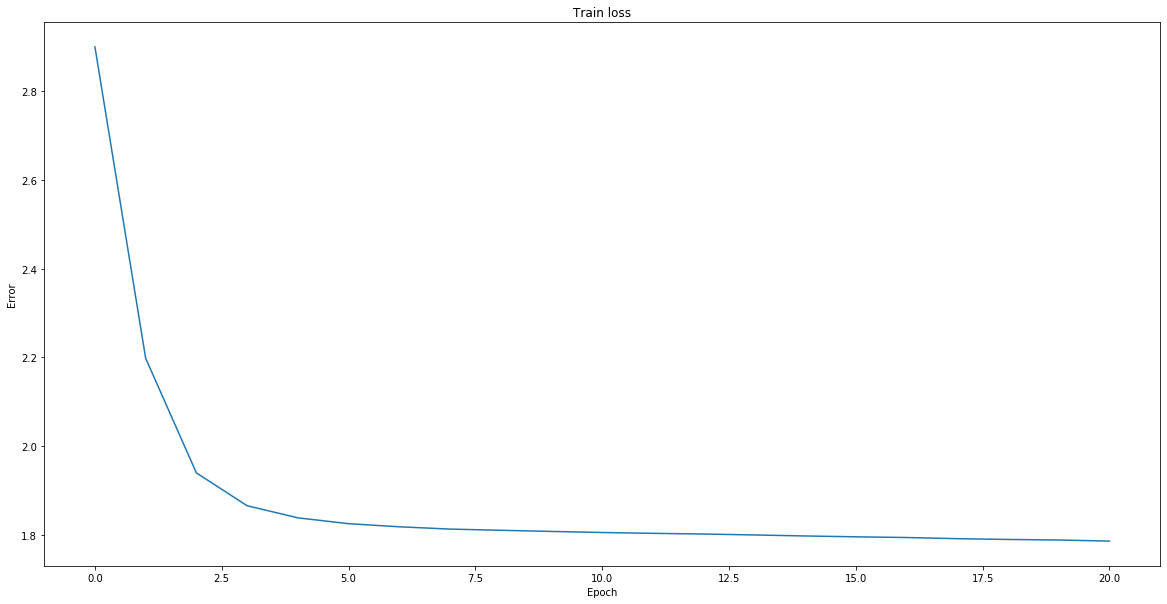

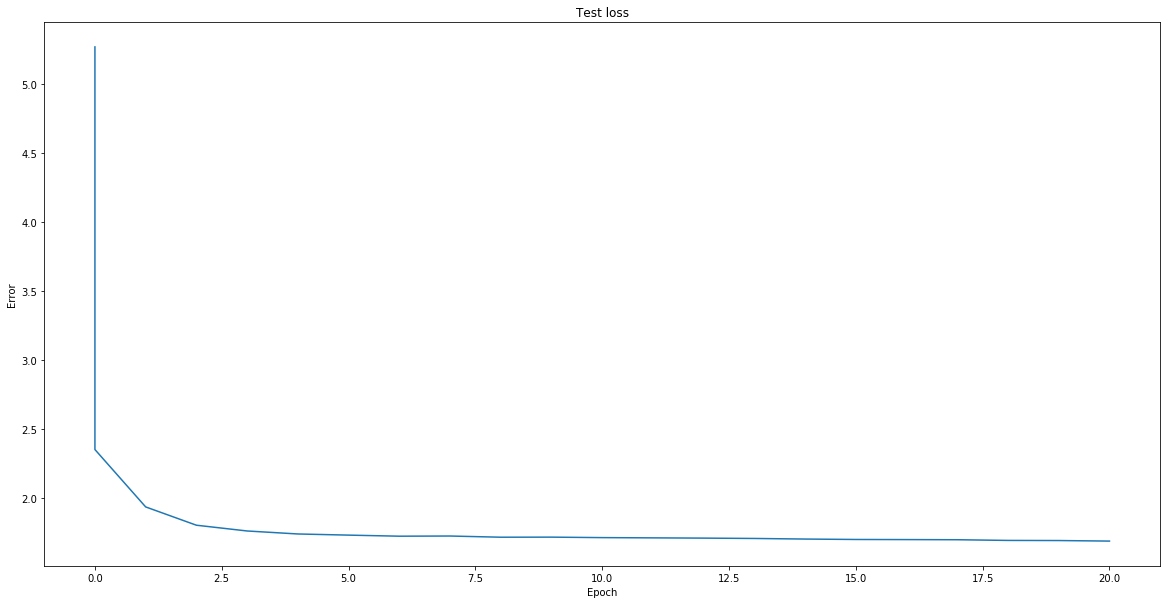

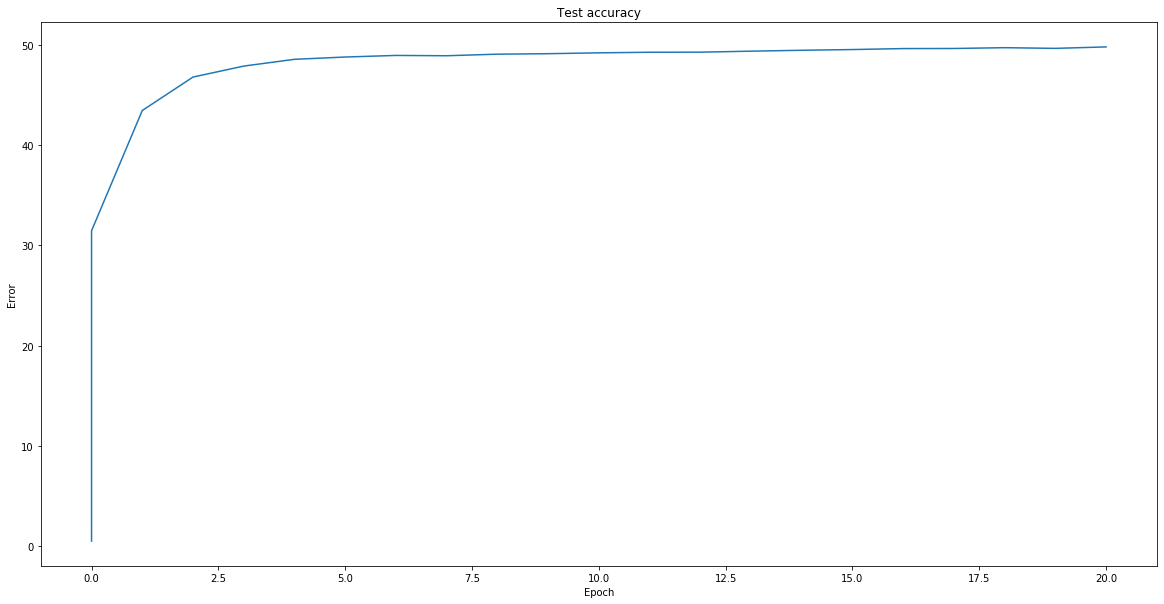

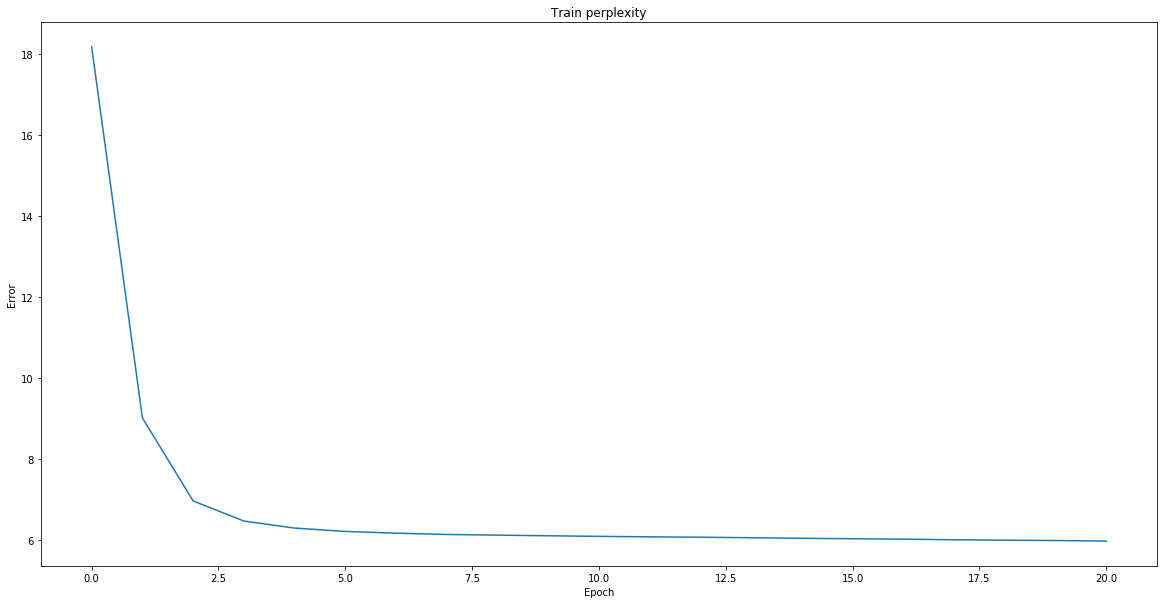

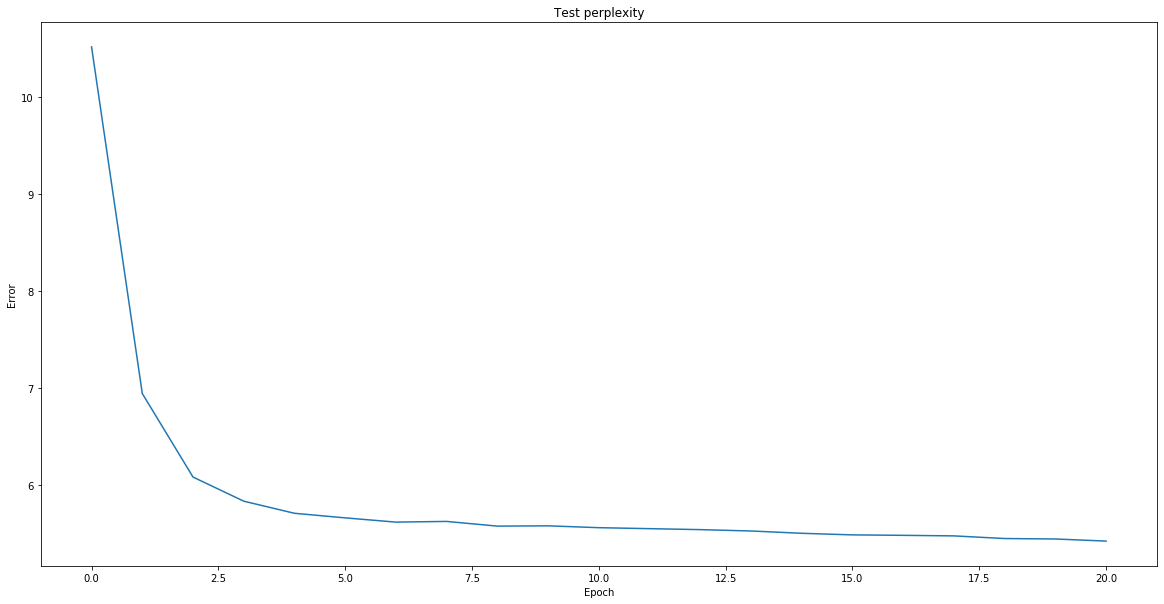

In [23]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 50
    LOG_PATH = DATA_PATH + 'logs/log.pkl'

###############################################################################
# Load data
###############################################################################
    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = TransformerModel(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')

    train_losses, test_losses, test_accuracies,train_ppls, test_ppls= pt_util.read_log(LOG_PATH, ([], [], [],[],[]))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            train_ppl = math.exp(train_loss)
            test_loss, test_accuracy = test(model, device, test_loader)
            test_ppl = math.exp(test_loss)
            train_ppls.append((epoch,train_ppl))
            test_ppls.append((epoch, test_ppl))
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies,train_ppls, test_ppls))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
    
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            #generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            #print('generated max\t\t', generated_sentence)
            #for ii in range(10):
                #generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                #print('generated sample\t', generated_sentence)
            #generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            #print('generated beam\t\t', generated_sentence)
            #print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        ep, val = zip(*train_ppls)
        pt_util.plot(ep, val, 'Train perplexity', 'Epoch', 'Error')
        ep, val = zip(*test_ppls)
        pt_util.plot(ep, val, 'Test perplexity', 'Epoch', 'Error')
        return model, vocab, device

final_model, vocab, device = main()

Using device cuda
num workers: 2
Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	Hh%ZdGZ~Dhy``/AFXa & AZX1/N/U~ZGIaZaz  \/Zazqq)H??HN)X)a ;QQQ%HIaHI rA1Q?HR.TG!aRvMTfZUU\N%ZUdrAZMMM


Input	 dragged. "Save your energy, sir. . . . We'll soon be out of here. . . ." "The archway will have sea
GT	dragged. "Save your energy, sir. . . . We'll soon be out of here. . . ." "The archway will have seal
pred	H!Pz11ZA1H?uNV Zf0?]ZNZaZ1sfZ)U\QNQNQHQH!!!)xxUI0.Zpppp?GG0YGIaPasHQHQHQ:H??yaHX\zdazTX)DXxxI   ZUZ 


Input	... I can Apparate us both back . . . Don't worry. . . ." "I am not worried, Harry," said Dumbledore
GT	.. I can Apparate us both back . . . Don't worry. . . ." "I am not worried, Harry," said Dumbledore,
pred	QQQH]HHz/X2Llkdd~NZaUZppGI0prz;QQHQHQHH0.TGGaRvMTQ:QNQNQ:H??HN)X!dGGaRvMUZANZvqoMff^ZU rAZt"GpXaARoZ


Input	his 

  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 7.2550, Accuracy: 20197/1254400 (2%)



  1%|          | 2/195 [00:00<00:49,  3.91it/s]

Train Epoch: 0 [0/49920 (0%)]	Loss: 7.272282


  6%|▌         | 12/195 [00:02<00:37,  4.92it/s]

Train Epoch: 0 [2560/49920 (5%)]	Loss: 4.505214


 11%|█         | 21/195 [00:04<00:35,  4.85it/s]

Train Epoch: 0 [5120/49920 (10%)]	Loss: 2.708396


 16%|█▌        | 31/195 [00:06<00:33,  4.93it/s]

Train Epoch: 0 [7680/49920 (15%)]	Loss: 2.273351


 21%|██        | 41/195 [00:08<00:31,  4.95it/s]

Train Epoch: 0 [10240/49920 (21%)]	Loss: 2.112975


 27%|██▋       | 52/195 [00:10<00:28,  5.02it/s]

Train Epoch: 0 [12800/49920 (26%)]	Loss: 2.036758


 31%|███▏      | 61/195 [00:12<00:27,  4.92it/s]

Train Epoch: 0 [15360/49920 (31%)]	Loss: 1.988037


 37%|███▋      | 72/195 [00:14<00:24,  4.95it/s]

Train Epoch: 0 [17920/49920 (36%)]	Loss: 1.937911


 42%|████▏     | 82/195 [00:16<00:23,  4.91it/s]

Train Epoch: 0 [20480/49920 (41%)]	Loss: 1.884041


 47%|████▋     | 92/195 [00:18<00:20,  4.95it/s]

Train Epoch: 0 [23040/49920 (46%)]	Loss: 1.859603


 52%|█████▏    | 101/195 [00:20<00:19,  4.90it/s]

Train Epoch: 0 [25600/49920 (51%)]	Loss: 1.831851


 57%|█████▋    | 111/195 [00:22<00:17,  4.92it/s]

Train Epoch: 0 [28160/49920 (56%)]	Loss: 1.807379


 63%|██████▎   | 122/195 [00:24<00:14,  4.97it/s]

Train Epoch: 0 [30720/49920 (62%)]	Loss: 1.797822


 67%|██████▋   | 131/195 [00:26<00:13,  4.80it/s]

Train Epoch: 0 [33280/49920 (67%)]	Loss: 1.768248


 73%|███████▎  | 142/195 [00:28<00:10,  4.93it/s]

Train Epoch: 0 [35840/49920 (72%)]	Loss: 1.767861


 78%|███████▊  | 152/195 [00:31<00:08,  4.94it/s]

Train Epoch: 0 [38400/49920 (77%)]	Loss: 1.757902


 83%|████████▎ | 162/195 [00:33<00:06,  4.89it/s]

Train Epoch: 0 [40960/49920 (82%)]	Loss: 1.728414


 88%|████████▊ | 171/195 [00:34<00:04,  4.97it/s]

Train Epoch: 0 [43520/49920 (87%)]	Loss: 1.698489


 93%|█████████▎| 181/195 [00:36<00:02,  4.98it/s]

Train Epoch: 0 [46080/49920 (92%)]	Loss: 1.701471


 98%|█████████▊| 192/195 [00:39<00:00,  4.99it/s]

Train Epoch: 0 [48640/49920 (97%)]	Loss: 1.679806


100%|██████████| 195/195 [00:39<00:00,  5.60it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	hooaththdhttnd totstd tnain,  toe sane   thsl  "W dnptarr  .  "e said  "Hon't hardi  sade  said Harr


Input	 dragged. "Save your energy, sir. . . . We'll soon be out of here. . . ." "The archway will have sea
GT	dragged. "Save your energy, sir. . . . We'll soon be out of here. . . ." "The archway will have seal
pred	hieiee   "Whie tou  tntd e  aade " . . .eall temm teeaft tf te    " . .  "Whe wnoheas satl tede taet


Input	... I can Apparate us both back . . . Don't worry. . . ." "I am not worried, Harry," said Dumbledore
GT	.. I can Apparate us both back . . . Don't worry. . . ." "I am not worried, Harry," said Dumbledore,
pred	 . I wan trrertcedtpttetteteck t . . .ub't tardi  " . .  "W dnptot tardied  aarry   said Humbledore 


Input	his eyes: the smell of salt, the sea 

  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 1.7204, Accuracy: 623966/1254400 (50%)

Saved /content/checkpoints/000.pt



  1%|          | 1/195 [00:00<01:00,  3.18it/s]

Train Epoch: 1 [0/49920 (0%)]	Loss: 1.689616


  6%|▌         | 11/195 [00:02<00:38,  4.75it/s]

Train Epoch: 1 [2560/49920 (5%)]	Loss: 1.662158


 11%|█         | 21/195 [00:04<00:35,  4.88it/s]

Train Epoch: 1 [5120/49920 (10%)]	Loss: 1.641555


 16%|█▌        | 31/195 [00:06<00:33,  4.83it/s]

Train Epoch: 1 [7680/49920 (15%)]	Loss: 1.643325


 22%|██▏       | 42/195 [00:08<00:30,  4.94it/s]

Train Epoch: 1 [10240/49920 (21%)]	Loss: 1.621514


 27%|██▋       | 52/195 [00:10<00:29,  4.85it/s]

Train Epoch: 1 [12800/49920 (26%)]	Loss: 1.648396


 31%|███▏      | 61/195 [00:12<00:28,  4.74it/s]

Train Epoch: 1 [15360/49920 (31%)]	Loss: 1.634381


 36%|███▋      | 71/195 [00:14<00:25,  4.81it/s]

Train Epoch: 1 [17920/49920 (36%)]	Loss: 1.605931


 42%|████▏     | 81/195 [00:16<00:23,  4.85it/s]

Train Epoch: 1 [20480/49920 (41%)]	Loss: 1.585216


 47%|████▋     | 91/195 [00:18<00:21,  4.93it/s]

Train Epoch: 1 [23040/49920 (46%)]	Loss: 1.582640


 52%|█████▏    | 101/195 [00:20<00:19,  4.82it/s]

Train Epoch: 1 [25600/49920 (51%)]	Loss: 1.577423


 57%|█████▋    | 112/195 [00:23<00:16,  4.93it/s]

Train Epoch: 1 [28160/49920 (56%)]	Loss: 1.569269


 63%|██████▎   | 122/195 [00:25<00:15,  4.84it/s]

Train Epoch: 1 [30720/49920 (62%)]	Loss: 1.578677


 68%|██████▊   | 132/195 [00:27<00:12,  4.93it/s]

Train Epoch: 1 [33280/49920 (67%)]	Loss: 1.569625


 72%|███████▏  | 141/195 [00:29<00:11,  4.79it/s]

Train Epoch: 1 [35840/49920 (72%)]	Loss: 1.568470


 77%|███████▋  | 151/195 [00:31<00:08,  4.93it/s]

Train Epoch: 1 [38400/49920 (77%)]	Loss: 1.572788


 83%|████████▎ | 161/195 [00:33<00:06,  4.89it/s]

Train Epoch: 1 [40960/49920 (82%)]	Loss: 1.551269


 88%|████████▊ | 172/195 [00:35<00:04,  4.94it/s]

Train Epoch: 1 [43520/49920 (87%)]	Loss: 1.530143


 93%|█████████▎| 181/195 [00:37<00:02,  4.82it/s]

Train Epoch: 1 [46080/49920 (92%)]	Loss: 1.532136


 98%|█████████▊| 192/195 [00:39<00:00,  4.91it/s]

Train Epoch: 1 [48640/49920 (97%)]	Loss: 1.530019


100%|██████████| 195/195 [00:40<00:00,  5.46it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	toeathhhlhttnd toastd tnainst the care  ohasl  "I ds tirr  .  "e said  "Ion'  wauky  worr  said Harr


Input	 dragged. "Save your energy, sir. . . . We'll soon be out of here. . . ." "The archway will have sea
GT	dragged. "Save your energy, sir. . . . We'll soon be out of here. . . ." "The archway will have seal
pred	.iewoed  "Ihie tou  sxdr e  todr " . . .eall be m te aft of tir   " . .  "Iherwneheasstatl have thet


Input	... I can Apparate us both back . . . Don't worry. . . ." "I am not worried, Harry," said Dumbledore
GT	.. I can Apparate us both back . . . Don't worry. . . ." "I am not worried, Harry," said Dumbledore,
pred	   I wan tlparacidtp teth teck t . . .ub'  wauky  " . .  "I ds tot tardyed  aarry   said Humbledore 


Input	his eyes: the smell of salt, the sea 

  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 1.5902, Accuracy: 670610/1254400 (53%)

Saved /content/checkpoints/001.pt



  1%|          | 2/195 [00:00<00:49,  3.87it/s]

Train Epoch: 2 [0/49920 (0%)]	Loss: 1.544432


  6%|▌         | 12/195 [00:02<00:37,  4.94it/s]

Train Epoch: 2 [2560/49920 (5%)]	Loss: 1.527284


 11%|█         | 21/195 [00:04<00:36,  4.74it/s]

Train Epoch: 2 [5120/49920 (10%)]	Loss: 1.508185


 16%|█▋        | 32/195 [00:06<00:32,  4.95it/s]

Train Epoch: 2 [7680/49920 (15%)]	Loss: 1.526616


 21%|██        | 41/195 [00:08<00:31,  4.82it/s]

Train Epoch: 2 [10240/49920 (21%)]	Loss: 1.494842


 26%|██▌       | 51/195 [00:10<00:29,  4.92it/s]

Train Epoch: 2 [12800/49920 (26%)]	Loss: 1.527588


 31%|███▏      | 61/195 [00:12<00:27,  4.92it/s]

Train Epoch: 2 [15360/49920 (31%)]	Loss: 1.523991


 37%|███▋      | 72/195 [00:14<00:25,  4.89it/s]

Train Epoch: 2 [17920/49920 (36%)]	Loss: 1.498920


 42%|████▏     | 81/195 [00:16<00:22,  4.96it/s]

Train Epoch: 2 [20480/49920 (41%)]	Loss: 1.482221


 47%|████▋     | 91/195 [00:18<00:21,  4.81it/s]

Train Epoch: 2 [23040/49920 (46%)]	Loss: 1.490037


 52%|█████▏    | 102/195 [00:20<00:18,  4.95it/s]

Train Epoch: 2 [25600/49920 (51%)]	Loss: 1.488081


 57%|█████▋    | 111/195 [00:22<00:17,  4.77it/s]

Train Epoch: 2 [28160/49920 (56%)]	Loss: 1.476503


 63%|██████▎   | 122/195 [00:25<00:14,  4.90it/s]

Train Epoch: 2 [30720/49920 (62%)]	Loss: 1.496184


 67%|██████▋   | 131/195 [00:26<00:13,  4.87it/s]

Train Epoch: 2 [33280/49920 (67%)]	Loss: 1.494620


 73%|███████▎  | 142/195 [00:29<00:10,  4.96it/s]

Train Epoch: 2 [35840/49920 (72%)]	Loss: 1.490169


 78%|███████▊  | 152/195 [00:31<00:08,  4.98it/s]

Train Epoch: 2 [38400/49920 (77%)]	Loss: 1.494137


 83%|████████▎ | 161/195 [00:33<00:07,  4.80it/s]

Train Epoch: 2 [40960/49920 (82%)]	Loss: 1.470353


 88%|████████▊ | 172/195 [00:35<00:04,  4.94it/s]

Train Epoch: 2 [43520/49920 (87%)]	Loss: 1.458389


 93%|█████████▎| 181/195 [00:37<00:02,  4.88it/s]

Train Epoch: 2 [46080/49920 (92%)]	Loss: 1.459054


 98%|█████████▊| 191/195 [00:39<00:00,  4.90it/s]

Train Epoch: 2 [48640/49920 (97%)]	Loss: 1.457259


100%|██████████| 195/195 [00:39<00:00,  5.53it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	toeat ahlhtt d toared atainst the slre  ahhsl  "I ts tarre .  "e said  "Io 't wauky  wot,  said Harr


Input	 dragged. "Save your energy, sir. . . . We'll soon be out of here. . . ." "The archway will have sea
GT	dragged. "Save your energy, sir. . . . We'll soon be out of here. . . ." "The archway will have seal
pred	.iegoed  "Ihie you  fvoa e  tol, " . . .eall be m te ant of tir   " . .  "Iherwneheasstatl have toer


Input	... I can Apparate us both back . . . Don't worry. . . ." "I am not worried, Harry," said Dumbledore
GT	.. I can Apparate us both back . . . Don't worry. . . ." "I am not worried, Harry," said Dumbledore,
pred	   I tan't perate tp aeth teck t . . .ub't wauky  " . .  "I dn tot taukyed  aarry   said Humbledore 


Input	his eyes: the smell of salt, the sea 

  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 1.5290, Accuracy: 689901/1254400 (55%)

Saved /content/checkpoints/002.pt



  1%|          | 2/195 [00:00<00:49,  3.88it/s]

Train Epoch: 3 [0/49920 (0%)]	Loss: 1.476024


  6%|▌         | 11/195 [00:02<00:37,  4.87it/s]

Train Epoch: 3 [2560/49920 (5%)]	Loss: 1.459028


 11%|█         | 21/195 [00:04<00:35,  4.92it/s]

Train Epoch: 3 [5120/49920 (10%)]	Loss: 1.441390


 16%|█▌        | 31/195 [00:06<00:33,  4.86it/s]

Train Epoch: 3 [7680/49920 (15%)]	Loss: 1.458907


 22%|██▏       | 42/195 [00:08<00:30,  4.98it/s]

Train Epoch: 3 [10240/49920 (21%)]	Loss: 1.442398


 26%|██▌       | 51/195 [00:10<00:28,  4.98it/s]

Train Epoch: 3 [12800/49920 (26%)]	Loss: 1.468899


 31%|███▏      | 61/195 [00:12<00:26,  4.98it/s]

Train Epoch: 3 [15360/49920 (31%)]	Loss: 1.463843


 37%|███▋      | 72/195 [00:14<00:24,  4.98it/s]

Train Epoch: 3 [17920/49920 (36%)]	Loss: 1.443057


 42%|████▏     | 81/195 [00:16<00:23,  4.86it/s]

Train Epoch: 3 [20480/49920 (41%)]	Loss: 1.420628


 47%|████▋     | 91/195 [00:18<00:21,  4.95it/s]

Train Epoch: 3 [23040/49920 (46%)]	Loss: 1.428001


 52%|█████▏    | 101/195 [00:20<00:19,  4.94it/s]

Train Epoch: 3 [25600/49920 (51%)]	Loss: 1.437603


 57%|█████▋    | 112/195 [00:22<00:16,  4.95it/s]

Train Epoch: 3 [28160/49920 (56%)]	Loss: 1.424984


 62%|██████▏   | 121/195 [00:24<00:15,  4.91it/s]

Train Epoch: 3 [30720/49920 (62%)]	Loss: 1.459648


 67%|██████▋   | 131/195 [00:26<00:13,  4.91it/s]

Train Epoch: 3 [33280/49920 (67%)]	Loss: 1.463359


 73%|███████▎  | 142/195 [00:28<00:10,  4.96it/s]

Train Epoch: 3 [35840/49920 (72%)]	Loss: 1.453203


 77%|███████▋  | 151/195 [00:30<00:08,  4.95it/s]

Train Epoch: 3 [38400/49920 (77%)]	Loss: 1.443660


 83%|████████▎ | 161/195 [00:32<00:06,  4.91it/s]

Train Epoch: 3 [40960/49920 (82%)]	Loss: 1.429803


 88%|████████▊ | 171/195 [00:34<00:04,  4.92it/s]

Train Epoch: 3 [43520/49920 (87%)]	Loss: 1.416542


 93%|█████████▎| 182/195 [00:37<00:02,  4.94it/s]

Train Epoch: 3 [46080/49920 (92%)]	Loss: 1.423340


 98%|█████████▊| 192/195 [00:39<00:00,  4.99it/s]

Train Epoch: 3 [48640/49920 (97%)]	Loss: 1.418209


100%|██████████| 195/195 [00:39<00:00,  5.58it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	toeat atlhta d aoared atainst the slre yohhsl  "I ts ta re .  "e said  "Iu 't wauky  Iot,  said Harr


Input	 dragged. "Save your energy, sir. . . . We'll soon be out of here. . . ." "The archway will have sea
GT	dragged. "Save your energy, sir. . . . We'll soon be out of here. . . ." "The archway will have seal
pred	.iagoe   "Ihie you  snor e  aol, I . . .hlll be n aetant of tir .." . .  "Iherwneheaystetl bave ttet


Input	... I can Apparate us both back . . . Don't worry. . . ." "I am not worried, Harry," said Dumbledore
GT	.. I can Apparate us both back . . . Don't worry. . . ." "I am not worried, Harry," said Dumbledore,
pred	   y ton t parate ts aeth oeck t . . .ub't wauky .I . .  "I ss tot taukyed  aarry   said Humbledore.


Input	his eyes: the smell of salt, the sea 

  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 1.4936, Accuracy: 698600/1254400 (56%)

Saved /content/checkpoints/003.pt



  1%|          | 2/195 [00:00<00:52,  3.70it/s]

Train Epoch: 4 [0/49920 (0%)]	Loss: 1.437920


  6%|▌         | 11/195 [00:02<00:38,  4.78it/s]

Train Epoch: 4 [2560/49920 (5%)]	Loss: 1.426125


 11%|█         | 21/195 [00:04<00:35,  4.84it/s]

Train Epoch: 4 [5120/49920 (10%)]	Loss: 1.406395


 16%|█▋        | 32/195 [00:06<00:33,  4.89it/s]

Train Epoch: 4 [7680/49920 (15%)]	Loss: 1.419759


 21%|██        | 41/195 [00:08<00:32,  4.81it/s]

Train Epoch: 4 [10240/49920 (21%)]	Loss: 1.399437


 26%|██▌       | 51/195 [00:10<00:29,  4.85it/s]

Train Epoch: 4 [12800/49920 (26%)]	Loss: 1.428781


 31%|███▏      | 61/195 [00:12<00:28,  4.75it/s]

Train Epoch: 4 [15360/49920 (31%)]	Loss: 1.431090


 36%|███▋      | 71/195 [00:14<00:25,  4.87it/s]

Train Epoch: 4 [17920/49920 (36%)]	Loss: 1.419307


 42%|████▏     | 81/195 [00:16<00:23,  4.85it/s]

Train Epoch: 4 [20480/49920 (41%)]	Loss: 1.396481


 47%|████▋     | 91/195 [00:18<00:21,  4.93it/s]

Train Epoch: 4 [23040/49920 (46%)]	Loss: 1.398488


 52%|█████▏    | 102/195 [00:21<00:19,  4.88it/s]

Train Epoch: 4 [25600/49920 (51%)]	Loss: 1.435260


 57%|█████▋    | 111/195 [00:23<00:17,  4.85it/s]

Train Epoch: 4 [28160/49920 (56%)]	Loss: 1.403044


 62%|██████▏   | 121/195 [00:25<00:15,  4.83it/s]

Train Epoch: 4 [30720/49920 (62%)]	Loss: 1.429626


 68%|██████▊   | 132/195 [00:27<00:12,  4.85it/s]

Train Epoch: 4 [33280/49920 (67%)]	Loss: 1.422154


 72%|███████▏  | 141/195 [00:29<00:11,  4.88it/s]

Train Epoch: 4 [35840/49920 (72%)]	Loss: 1.417315


 77%|███████▋  | 151/195 [00:31<00:09,  4.87it/s]

Train Epoch: 4 [38400/49920 (77%)]	Loss: 1.425244


 83%|████████▎ | 161/195 [00:33<00:06,  4.89it/s]

Train Epoch: 4 [40960/49920 (82%)]	Loss: 1.408889


 88%|████████▊ | 172/195 [00:35<00:04,  4.90it/s]

Train Epoch: 4 [43520/49920 (87%)]	Loss: 1.397991


 93%|█████████▎| 181/195 [00:37<00:02,  4.82it/s]

Train Epoch: 4 [46080/49920 (92%)]	Loss: 1.407510


 98%|█████████▊| 191/195 [00:39<00:00,  4.74it/s]

Train Epoch: 4 [48640/49920 (97%)]	Loss: 1.397806


100%|██████████| 195/195 [00:40<00:00,  5.41it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	toeat atlhtand aoared atainst the sore yohasl  "I ts terre".  "e said  "Io 't warky "Iol,  said Harr


Input	 dragged. "Save your energy, sir. . . . We'll soon be out of here. . . ." "The archway will have sea
GT	dragged. "Save your energy, sir. . . . We'll soon be out of here. . . ." "The archway will have seal
pred	.iagoed ""Ihie you  sndr e  Iol, I . . .elll be n aetant of tir ."I . .  "Ihersneheayswatl bave ttet


Input	... I can Apparate us both back . . . Don't worry. . . ." "I am not worried, Harry," said Dumbledore
GT	.. I can Apparate us both back . . . Don't worry. . . ." "I am not worried, Harry," said Dumbledore,
pred	   I ton t parate ts aeth ouck t . . .ub't wauky "I . .  "I sm tot sarkyed "aarry,  said Humbledore.


Input	his eyes: the smell of salt, the sea 

  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 1.4742, Accuracy: 704988/1254400 (56%)

Saved /content/checkpoints/004.pt



  1%|          | 2/195 [00:00<00:49,  3.88it/s]

Train Epoch: 5 [0/49920 (0%)]	Loss: 1.418253


  6%|▌         | 11/195 [00:02<00:38,  4.78it/s]

Train Epoch: 5 [2560/49920 (5%)]	Loss: 1.410584


 11%|█▏        | 22/195 [00:04<00:34,  4.96it/s]

Train Epoch: 5 [5120/49920 (10%)]	Loss: 1.405162


 16%|█▌        | 31/195 [00:06<00:33,  4.88it/s]

Train Epoch: 5 [7680/49920 (15%)]	Loss: 1.407016


 22%|██▏       | 42/195 [00:08<00:31,  4.91it/s]

Train Epoch: 5 [10240/49920 (21%)]	Loss: 1.386086


 27%|██▋       | 52/195 [00:10<00:28,  4.98it/s]

Train Epoch: 5 [12800/49920 (26%)]	Loss: 1.415443


 31%|███▏      | 61/195 [00:12<00:27,  4.79it/s]

Train Epoch: 5 [15360/49920 (31%)]	Loss: 1.414457


 36%|███▋      | 71/195 [00:14<00:25,  4.92it/s]

Train Epoch: 5 [17920/49920 (36%)]	Loss: 1.404031


 42%|████▏     | 81/195 [00:16<00:23,  4.80it/s]

Train Epoch: 5 [20480/49920 (41%)]	Loss: 1.380732


 47%|████▋     | 91/195 [00:18<00:21,  4.91it/s]

Train Epoch: 5 [23040/49920 (46%)]	Loss: 1.380545


 52%|█████▏    | 101/195 [00:20<00:19,  4.86it/s]

Train Epoch: 5 [25600/49920 (51%)]	Loss: 1.410713


 57%|█████▋    | 112/195 [00:23<00:16,  4.92it/s]

Train Epoch: 5 [28160/49920 (56%)]	Loss: 1.383443


 62%|██████▏   | 121/195 [00:24<00:15,  4.87it/s]

Train Epoch: 5 [30720/49920 (62%)]	Loss: 1.411305


 67%|██████▋   | 131/195 [00:26<00:13,  4.86it/s]

Train Epoch: 5 [33280/49920 (67%)]	Loss: 1.402349


 72%|███████▏  | 141/195 [00:28<00:10,  4.97it/s]

Train Epoch: 5 [35840/49920 (72%)]	Loss: 1.406866


 77%|███████▋  | 151/195 [00:31<00:09,  4.78it/s]

Train Epoch: 5 [38400/49920 (77%)]	Loss: 1.415566


 83%|████████▎ | 162/195 [00:33<00:06,  4.95it/s]

Train Epoch: 5 [40960/49920 (82%)]	Loss: 1.399991


 88%|████████▊ | 171/195 [00:35<00:04,  4.90it/s]

Train Epoch: 5 [43520/49920 (87%)]	Loss: 1.386253


 93%|█████████▎| 182/195 [00:37<00:02,  4.91it/s]

Train Epoch: 5 [46080/49920 (92%)]	Loss: 1.389990


 98%|█████████▊| 192/195 [00:39<00:00,  4.95it/s]

Train Epoch: 5 [48640/49920 (97%)]	Loss: 1.392755


100%|██████████| 195/195 [00:39<00:00,  5.46it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	toeat atlhtand aoared anainst the soreryoaasl  "I dm torre .  "e said  "Io 't warky  Ior,  said Harr


Input	 dragged. "Save your energy, sir. . . . We'll soon be out of here. . . ." "The archway will have sea
GT	dragged. "Save your energy, sir. . . . We'll soon be out of here. . . ." "The archway will have seal
pred	.iagoed ""Ioie you  sndr e  Iol, I . . .hlll be n auhant of tir ."" . .  "Ihersneheaysaatl bave toer


Input	... I can Apparate us both back . . . Don't worry. . . ." "I am not worried, Harry," said Dumbledore
GT	.. I can Apparate us both back . . . Don't worry. . . ." "I am not worried, Harry," said Dumbledore,
pred	   I ton t parate ts aeth ouck t . . .ub't warky .I . .  "I dm sot sarkyed "aarry,  said Humbledore.


Input	his eyes: the smell of salt, the sea 

  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 1.4681, Accuracy: 707825/1254400 (56%)

Saved /content/checkpoints/005.pt



  1%|          | 2/195 [00:00<00:51,  3.78it/s]

Train Epoch: 6 [0/49920 (0%)]	Loss: 1.411597


  6%|▌         | 12/195 [00:02<00:37,  4.86it/s]

Train Epoch: 6 [2560/49920 (5%)]	Loss: 1.400793


 11%|█▏        | 22/195 [00:04<00:34,  4.99it/s]

Train Epoch: 6 [5120/49920 (10%)]	Loss: 1.381660


 16%|█▌        | 31/195 [00:06<00:32,  4.98it/s]

Train Epoch: 6 [7680/49920 (15%)]	Loss: 1.397536


 21%|██        | 41/195 [00:08<00:30,  4.98it/s]

Train Epoch: 6 [10240/49920 (21%)]	Loss: 1.378404


 27%|██▋       | 52/195 [00:10<00:28,  5.02it/s]

Train Epoch: 6 [12800/49920 (26%)]	Loss: 1.405163


 32%|███▏      | 62/195 [00:12<00:26,  5.00it/s]

Train Epoch: 6 [15360/49920 (31%)]	Loss: 1.410893


 37%|███▋      | 72/195 [00:14<00:24,  4.99it/s]

Train Epoch: 6 [17920/49920 (36%)]	Loss: 1.405218


 42%|████▏     | 82/195 [00:16<00:22,  4.96it/s]

Train Epoch: 6 [20480/49920 (41%)]	Loss: 1.380941


 47%|████▋     | 92/195 [00:18<00:20,  4.97it/s]

Train Epoch: 6 [23040/49920 (46%)]	Loss: 1.374871


 52%|█████▏    | 101/195 [00:20<00:18,  5.01it/s]

Train Epoch: 6 [25600/49920 (51%)]	Loss: 1.390331


 57%|█████▋    | 112/195 [00:22<00:16,  4.97it/s]

Train Epoch: 6 [28160/49920 (56%)]	Loss: 1.370826


 62%|██████▏   | 121/195 [00:24<00:14,  5.00it/s]

Train Epoch: 6 [30720/49920 (62%)]	Loss: 1.410353


 68%|██████▊   | 132/195 [00:26<00:12,  5.01it/s]

Train Epoch: 6 [33280/49920 (67%)]	Loss: 1.424289


 73%|███████▎  | 142/195 [00:28<00:10,  5.02it/s]

Train Epoch: 6 [35840/49920 (72%)]	Loss: 1.405124


 77%|███████▋  | 151/195 [00:30<00:09,  4.88it/s]

Train Epoch: 6 [38400/49920 (77%)]	Loss: 1.401360


 83%|████████▎ | 161/195 [00:32<00:06,  4.88it/s]

Train Epoch: 6 [40960/49920 (82%)]	Loss: 1.383899


 88%|████████▊ | 171/195 [00:34<00:04,  4.95it/s]

Train Epoch: 6 [43520/49920 (87%)]	Loss: 1.376986


 93%|█████████▎| 181/195 [00:36<00:02,  4.97it/s]

Train Epoch: 6 [46080/49920 (92%)]	Loss: 1.382358


 98%|█████████▊| 192/195 [00:38<00:00,  4.98it/s]

Train Epoch: 6 [48640/49920 (97%)]	Loss: 1.384430


100%|██████████| 195/195 [00:39<00:00,  5.64it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	toeat atlhtand aetred ttainst the soreryeaasl  "I dm thrre".  "e said  "Iu 't warky  Ior,  said Harr


Input	 dragged. "Save your energy, sir. . . . We'll soon be out of here. . . ." "The archway will have sea
GT	dragged. "Save your energy, sir. . . . We'll soon be out of here. . . ." "The archway will have seal
pred	.iawoed "IIhie you  sydr e  aol, I . . .eall be n tutant of tir ."" . .  "Ihe creheayswatl bave ttet


Input	... I can Apparate us both back . . . Don't worry. . . ." "I am not worried, Harry," said Dumbledore
GT	.. I can Apparate us both back . . . Don't worry. . . ." "I am not worried, Harry," said Dumbledore,
pred	   I tan't parate tseaeth oeck t . . .ub't warky .I . .  "I dm tot sarkyed "aarry,  said Humbledore.


Input	his eyes: the smell of salt, the sea 

  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 1.4590, Accuracy: 712354/1254400 (57%)

Saved /content/checkpoints/006.pt



  1%|          | 1/195 [00:00<00:58,  3.32it/s]

Train Epoch: 7 [0/49920 (0%)]	Loss: 1.403625


  6%|▌         | 11/195 [00:02<00:38,  4.82it/s]

Train Epoch: 7 [2560/49920 (5%)]	Loss: 1.399675


 11%|█         | 21/195 [00:04<00:36,  4.83it/s]

Train Epoch: 7 [5120/49920 (10%)]	Loss: 1.366625


 16%|█▋        | 32/195 [00:06<00:32,  4.95it/s]

Train Epoch: 7 [7680/49920 (15%)]	Loss: 1.389873


 21%|██        | 41/195 [00:08<00:31,  4.85it/s]

Train Epoch: 7 [10240/49920 (21%)]	Loss: 1.371683


 26%|██▌       | 51/195 [00:10<00:29,  4.81it/s]

Train Epoch: 7 [12800/49920 (26%)]	Loss: 1.401600


 32%|███▏      | 62/195 [00:12<00:27,  4.87it/s]

Train Epoch: 7 [15360/49920 (31%)]	Loss: 1.403249


 36%|███▋      | 71/195 [00:14<00:25,  4.87it/s]

Train Epoch: 7 [17920/49920 (36%)]	Loss: 1.399315


 42%|████▏     | 81/195 [00:16<00:23,  4.85it/s]

Train Epoch: 7 [20480/49920 (41%)]	Loss: 1.372183


 47%|████▋     | 91/195 [00:18<00:20,  4.97it/s]

Train Epoch: 7 [23040/49920 (46%)]	Loss: 1.370126


 52%|█████▏    | 101/195 [00:20<00:19,  4.87it/s]

Train Epoch: 7 [25600/49920 (51%)]	Loss: 1.393906


 57%|█████▋    | 112/195 [00:23<00:16,  4.93it/s]

Train Epoch: 7 [28160/49920 (56%)]	Loss: 1.363826


 63%|██████▎   | 122/195 [00:25<00:14,  4.90it/s]

Train Epoch: 7 [30720/49920 (62%)]	Loss: 1.403080


 68%|██████▊   | 132/195 [00:27<00:12,  4.92it/s]

Train Epoch: 7 [33280/49920 (67%)]	Loss: 1.388447


 72%|███████▏  | 141/195 [00:29<00:11,  4.83it/s]

Train Epoch: 7 [35840/49920 (72%)]	Loss: 1.403883


 77%|███████▋  | 151/195 [00:31<00:08,  4.94it/s]

Train Epoch: 7 [38400/49920 (77%)]	Loss: 1.392102


 83%|████████▎ | 161/195 [00:33<00:06,  4.89it/s]

Train Epoch: 7 [40960/49920 (82%)]	Loss: 1.382676


 88%|████████▊ | 171/195 [00:35<00:04,  4.91it/s]

Train Epoch: 7 [43520/49920 (87%)]	Loss: 1.373584


 93%|█████████▎| 181/195 [00:37<00:02,  4.86it/s]

Train Epoch: 7 [46080/49920 (92%)]	Loss: 1.373984


 98%|█████████▊| 192/195 [00:39<00:00,  4.89it/s]

Train Epoch: 7 [48640/49920 (97%)]	Loss: 1.379298


100%|██████████| 195/195 [00:40<00:00,  5.54it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	toeat atlhtand aetred atainst the soreryeaatl  "I tm thlre".  "e said  "Iu 't tarky  Ior,  said Harr


Input	 dragged. "Save your energy, sir. . . . We'll soon be out of here. . . ." "The archway will have sea
GT	dragged. "Save your energy, sir. . . . We'll soon be out of here. . . ." "The archway will have seal
pred	.iewoed "IIhie you  dydr e "ahr, I . . .elll be n tetant of tir ,"" . .  "Ihe creheayswetl bave tuer


Input	... I can Apparate us both back . . . Don't worry. . . ." "I am not worried, Harry," said Dumbledore
GT	.. I can Apparate us both back . . . Don't worry. . . ." "I am not worried, Harry," said Dumbledore,
pred	   I tan't parate tseaeth oeck t . . .ub't wauky "I . .  "I dm tot sarkyed "aarry," said Humbledore.


Input	his eyes: the smell of salt, the sea 

  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 1.4587, Accuracy: 711462/1254400 (57%)



  1%|          | 2/195 [00:00<00:52,  3.69it/s]

Train Epoch: 8 [0/49920 (0%)]	Loss: 1.401533


  6%|▌         | 11/195 [00:02<00:38,  4.84it/s]

Train Epoch: 8 [2560/49920 (5%)]	Loss: 1.388821


 11%|█         | 21/195 [00:04<00:36,  4.81it/s]

Train Epoch: 8 [5120/49920 (10%)]	Loss: 1.363051


 16%|█▌        | 31/195 [00:06<00:33,  4.85it/s]

Train Epoch: 8 [7680/49920 (15%)]	Loss: 1.378823


 21%|██        | 41/195 [00:08<00:31,  4.84it/s]

Train Epoch: 8 [10240/49920 (21%)]	Loss: 1.367868


 26%|██▌       | 51/195 [00:10<00:29,  4.89it/s]

Train Epoch: 8 [12800/49920 (26%)]	Loss: 1.391915


 31%|███▏      | 61/195 [00:12<00:26,  4.98it/s]

Train Epoch: 8 [15360/49920 (31%)]	Loss: 1.397855


 37%|███▋      | 72/195 [00:14<00:25,  4.87it/s]

Train Epoch: 8 [17920/49920 (36%)]	Loss: 1.390054


 42%|████▏     | 81/195 [00:16<00:23,  4.87it/s]

Train Epoch: 8 [20480/49920 (41%)]	Loss: 1.364914


 47%|████▋     | 91/195 [00:18<00:21,  4.79it/s]

Train Epoch: 8 [23040/49920 (46%)]	Loss: 1.368669


 52%|█████▏    | 101/195 [00:20<00:19,  4.90it/s]

Train Epoch: 8 [25600/49920 (51%)]	Loss: 1.390472


 57%|█████▋    | 111/195 [00:22<00:17,  4.86it/s]

Train Epoch: 8 [28160/49920 (56%)]	Loss: 1.359716


 62%|██████▏   | 121/195 [00:24<00:14,  4.94it/s]

Train Epoch: 8 [30720/49920 (62%)]	Loss: 1.393865


 67%|██████▋   | 131/195 [00:26<00:13,  4.91it/s]

Train Epoch: 8 [33280/49920 (67%)]	Loss: 1.414834


 73%|███████▎  | 142/195 [00:29<00:10,  4.94it/s]

Train Epoch: 8 [35840/49920 (72%)]	Loss: 1.391724


 78%|███████▊  | 152/195 [00:31<00:08,  5.01it/s]

Train Epoch: 8 [38400/49920 (77%)]	Loss: 1.387902


 83%|████████▎ | 161/195 [00:33<00:07,  4.85it/s]

Train Epoch: 8 [40960/49920 (82%)]	Loss: 1.372884


 88%|████████▊ | 171/195 [00:35<00:04,  4.87it/s]

Train Epoch: 8 [43520/49920 (87%)]	Loss: 1.365216


 93%|█████████▎| 181/195 [00:37<00:02,  4.88it/s]

Train Epoch: 8 [46080/49920 (92%)]	Loss: 1.369038


 98%|█████████▊| 191/195 [00:39<00:00,  4.78it/s]

Train Epoch: 8 [48640/49920 (97%)]	Loss: 1.373752


100%|██████████| 195/195 [00:40<00:00,  5.53it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	tooat atlhtand tetred atainst the soreryeaatl  "I tm th re".  "e said  "Iu 't tanky  Ior,  said Harr


Input	 dragged. "Save your energy, sir. . . . We'll soon be out of here. . . ." "The archway will have sea
GT	dragged. "Save your energy, sir. . . . We'll soon be out of here. . . ." "The archway will have seal
pred	Ioewoed "IIhye you  dyoree "ahr, I . . .elll be n tetant of tir ,"" . .  "Ihe crehearsoetl bave tuer


Input	... I can Apparate us both back . . . Don't worry. . . ." "I am not worried, Harry," said Dumbledore
GT	.. I can Apparate us both back . . . Don't worry. . . ." "I am not worried, Harry," said Dumbledore,
pred	   I ton t rarate tseaeth oeck t . . .ub't wanky "I . .  "I sm tot sarkyed "aarry," said Humbledore.


Input	his eyes: the smell of salt, the sea 

  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 1.4520, Accuracy: 714490/1254400 (57%)

Saved /content/checkpoints/008.pt



  1%|          | 2/195 [00:00<00:50,  3.86it/s]

Train Epoch: 9 [0/49920 (0%)]	Loss: 1.395148


  6%|▌         | 12/195 [00:02<00:37,  4.93it/s]

Train Epoch: 9 [2560/49920 (5%)]	Loss: 1.396617


 11%|█         | 21/195 [00:04<00:35,  4.97it/s]

Train Epoch: 9 [5120/49920 (10%)]	Loss: 1.358643


 16%|█▌        | 31/195 [00:06<00:33,  4.97it/s]

Train Epoch: 9 [7680/49920 (15%)]	Loss: 1.370862


 22%|██▏       | 42/195 [00:08<00:31,  4.90it/s]

Train Epoch: 9 [10240/49920 (21%)]	Loss: 1.358744


 26%|██▌       | 51/195 [00:10<00:29,  4.90it/s]

Train Epoch: 9 [12800/49920 (26%)]	Loss: 1.388587


 31%|███▏      | 61/195 [00:12<00:27,  4.96it/s]

Train Epoch: 9 [15360/49920 (31%)]	Loss: 1.394534


 37%|███▋      | 72/195 [00:14<00:24,  4.99it/s]

Train Epoch: 9 [17920/49920 (36%)]	Loss: 1.382936


 42%|████▏     | 82/195 [00:16<00:22,  4.92it/s]

Train Epoch: 9 [20480/49920 (41%)]	Loss: 1.359135


 47%|████▋     | 91/195 [00:18<00:21,  4.90it/s]

Train Epoch: 9 [23040/49920 (46%)]	Loss: 1.357060


 52%|█████▏    | 101/195 [00:20<00:18,  4.96it/s]

Train Epoch: 9 [25600/49920 (51%)]	Loss: 1.388979


 57%|█████▋    | 112/195 [00:22<00:16,  4.94it/s]

Train Epoch: 9 [28160/49920 (56%)]	Loss: 1.352767


 62%|██████▏   | 121/195 [00:24<00:14,  4.98it/s]

Train Epoch: 9 [30720/49920 (62%)]	Loss: 1.386607


 67%|██████▋   | 131/195 [00:26<00:12,  4.98it/s]

Train Epoch: 9 [33280/49920 (67%)]	Loss: 1.415047


 73%|███████▎  | 142/195 [00:28<00:10,  5.00it/s]

Train Epoch: 9 [35840/49920 (72%)]	Loss: 1.395674


 78%|███████▊  | 152/195 [00:30<00:08,  4.98it/s]

Train Epoch: 9 [38400/49920 (77%)]	Loss: 1.386044


 83%|████████▎ | 161/195 [00:32<00:07,  4.86it/s]

Train Epoch: 9 [40960/49920 (82%)]	Loss: 1.368458


 88%|████████▊ | 171/195 [00:34<00:04,  4.82it/s]

Train Epoch: 9 [43520/49920 (87%)]	Loss: 1.356286


 93%|█████████▎| 182/195 [00:36<00:02,  4.97it/s]

Train Epoch: 9 [46080/49920 (92%)]	Loss: 1.364055


 98%|█████████▊| 191/195 [00:38<00:00,  4.91it/s]

Train Epoch: 9 [48640/49920 (97%)]	Loss: 1.367933


100%|██████████| 195/195 [00:39<00:00,  5.48it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	toeat aulhtand totred ttainst the soreryoaatl  "I tm th ri".  "e said  "Iu 't tanky  Ior,  said Harr


Input	 dragged. "Save your energy, sir. . . . We'll soon be out of here. . . ." "The archway will have sea
GT	dragged. "Save your energy, sir. . . . We'll soon be out of here. . . ." "The archway will have seal
pred	Ioenoed "IIoye you  dyoree "aor  I . . .elll be n tetant of tir ,"I . .  "Iha crrhear,aatl bave tuer


Input	... I can Apparate us both back . . . Don't worry. . . ." "I am not worried, Harry," said Dumbledore
GT	.. I can Apparate us both back . . . Don't worry. . . ." "I am not worried, Harry," said Dumbledore,
pred	   I ton tnparate ts aeth oeck t . . .ub't tanky "I . .  "I tm tot tarkyed "aarry," said Humbledore.


Input	his eyes: the smell of salt, the sea 

  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 1.4474, Accuracy: 715995/1254400 (57%)

Saved /content/checkpoints/009.pt



  1%|          | 1/195 [00:00<00:59,  3.26it/s]

Train Epoch: 10 [0/49920 (0%)]	Loss: 1.390587


  6%|▌         | 11/195 [00:02<00:38,  4.80it/s]

Train Epoch: 10 [2560/49920 (5%)]	Loss: 1.381671


 11%|█         | 21/195 [00:04<00:35,  4.88it/s]

Train Epoch: 10 [5120/49920 (10%)]	Loss: 1.353238


 16%|█▋        | 32/195 [00:06<00:33,  4.84it/s]

Train Epoch: 10 [7680/49920 (15%)]	Loss: 1.364723


 22%|██▏       | 42/195 [00:08<00:30,  4.96it/s]

Train Epoch: 10 [10240/49920 (21%)]	Loss: 1.350111


 26%|██▌       | 51/195 [00:10<00:29,  4.82it/s]

Train Epoch: 10 [12800/49920 (26%)]	Loss: 1.381783


 31%|███▏      | 61/195 [00:12<00:28,  4.73it/s]

Train Epoch: 10 [15360/49920 (31%)]	Loss: 1.391670


 36%|███▋      | 71/195 [00:14<00:25,  4.86it/s]

Train Epoch: 10 [17920/49920 (36%)]	Loss: 1.375885


 42%|████▏     | 81/195 [00:16<00:23,  4.78it/s]

Train Epoch: 10 [20480/49920 (41%)]	Loss: 1.353580


 47%|████▋     | 91/195 [00:18<00:21,  4.84it/s]

Train Epoch: 10 [23040/49920 (46%)]	Loss: 1.349949


 52%|█████▏    | 102/195 [00:21<00:18,  4.90it/s]

Train Epoch: 10 [25600/49920 (51%)]	Loss: 1.373843


 57%|█████▋    | 111/195 [00:23<00:17,  4.81it/s]

Train Epoch: 10 [28160/49920 (56%)]	Loss: 1.345598


 62%|██████▏   | 121/195 [00:25<00:15,  4.85it/s]

Train Epoch: 10 [30720/49920 (62%)]	Loss: 1.375002


 68%|██████▊   | 132/195 [00:27<00:12,  4.89it/s]

Train Epoch: 10 [33280/49920 (67%)]	Loss: 1.404026


 72%|███████▏  | 141/195 [00:29<00:11,  4.80it/s]

Train Epoch: 10 [35840/49920 (72%)]	Loss: 1.391740


 77%|███████▋  | 151/195 [00:31<00:09,  4.85it/s]

Train Epoch: 10 [38400/49920 (77%)]	Loss: 1.381819


 83%|████████▎ | 161/195 [00:33<00:07,  4.86it/s]

Train Epoch: 10 [40960/49920 (82%)]	Loss: 1.362897


 88%|████████▊ | 172/195 [00:35<00:04,  4.90it/s]

Train Epoch: 10 [43520/49920 (87%)]	Loss: 1.352307


 93%|█████████▎| 182/195 [00:37<00:02,  4.96it/s]

Train Epoch: 10 [46080/49920 (92%)]	Loss: 1.357637


 98%|█████████▊| 191/195 [00:39<00:00,  4.72it/s]

Train Epoch: 10 [48640/49920 (97%)]	Loss: 1.363845


100%|██████████| 195/195 [00:40<00:00,  5.50it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	toeat tulhtond tetred ttainst the soreryooatl  "I tm th ri".  "e said  "Iu 't tarky  aor,  said Harr


Input	 dragged. "Save your energy, sir. . . . We'll soon be out of here. . . ." "The archway will have sea
GT	dragged. "Save your energy, sir. . . . We'll soon be out of here. . . ." "The archway will have seal
pred	Ioewoed "IIoye you  dyoree "aor  I . . .elll be n tetant of tir ,"I . .  "Iha crmhear,tatl bave tuer


Input	... I can Apparate us both back . . . Don't worry. . . ." "I am not worried, Harry," said Dumbledore
GT	.. I can Apparate us both back . . . Don't worry. . . ." "I am not worried, Harry," said Dumbledore,
pred	   I tan t parate tseaeth oeck t . . .ub't tarky "I . .  "I ts tot tarkyed "aarry," said Humbledore.


Input	his eyes: the smell of salt, the sea 

  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 1.4406, Accuracy: 718422/1254400 (57%)

Saved /content/checkpoints/010.pt



  1%|          | 2/195 [00:00<00:50,  3.79it/s]

Train Epoch: 11 [0/49920 (0%)]	Loss: 1.385522


  6%|▌         | 11/195 [00:02<00:38,  4.75it/s]

Train Epoch: 11 [2560/49920 (5%)]	Loss: 1.372174


 11%|█         | 21/195 [00:04<00:35,  4.91it/s]

Train Epoch: 11 [5120/49920 (10%)]	Loss: 1.350248


 16%|█▌        | 31/195 [00:06<00:33,  4.88it/s]

Train Epoch: 11 [7680/49920 (15%)]	Loss: 1.359921


 22%|██▏       | 42/195 [00:08<00:31,  4.92it/s]

Train Epoch: 11 [10240/49920 (21%)]	Loss: 1.345533


 26%|██▌       | 51/195 [00:10<00:29,  4.87it/s]

Train Epoch: 11 [12800/49920 (26%)]	Loss: 1.377292


 31%|███▏      | 61/195 [00:12<00:27,  4.83it/s]

Train Epoch: 11 [15360/49920 (31%)]	Loss: 1.385390


 36%|███▋      | 71/195 [00:14<00:25,  4.86it/s]

Train Epoch: 11 [17920/49920 (36%)]	Loss: 1.369227


 42%|████▏     | 81/195 [00:16<00:23,  4.77it/s]

Train Epoch: 11 [20480/49920 (41%)]	Loss: 1.348812


 47%|████▋     | 91/195 [00:18<00:21,  4.92it/s]

Train Epoch: 11 [23040/49920 (46%)]	Loss: 1.345140


 52%|█████▏    | 101/195 [00:20<00:19,  4.92it/s]

Train Epoch: 11 [25600/49920 (51%)]	Loss: 1.363553


 57%|█████▋    | 112/195 [00:23<00:16,  4.94it/s]

Train Epoch: 11 [28160/49920 (56%)]	Loss: 1.341123


 62%|██████▏   | 121/195 [00:24<00:15,  4.83it/s]

Train Epoch: 11 [30720/49920 (62%)]	Loss: 1.371018


 67%|██████▋   | 131/195 [00:26<00:13,  4.85it/s]

Train Epoch: 11 [33280/49920 (67%)]	Loss: 1.401737


 72%|███████▏  | 141/195 [00:29<00:10,  4.97it/s]

Train Epoch: 11 [35840/49920 (72%)]	Loss: 1.384666


 77%|███████▋  | 151/195 [00:31<00:09,  4.79it/s]

Train Epoch: 11 [38400/49920 (77%)]	Loss: 1.375462


 83%|████████▎ | 161/195 [00:33<00:06,  4.88it/s]

Train Epoch: 11 [40960/49920 (82%)]	Loss: 1.357925


 88%|████████▊ | 171/195 [00:35<00:04,  4.85it/s]

Train Epoch: 11 [43520/49920 (87%)]	Loss: 1.348905


 93%|█████████▎| 182/195 [00:37<00:02,  4.91it/s]

Train Epoch: 11 [46080/49920 (92%)]	Loss: 1.354109


 98%|█████████▊| 191/195 [00:39<00:00,  4.93it/s]

Train Epoch: 11 [48640/49920 (97%)]	Loss: 1.360000


100%|██████████| 195/195 [00:40<00:00,  5.48it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	toeat tulhtond tetred ttainst the soreriooatl  "I tm te ri".  "e said  "Iu 't tarky  aor,  said Harr


Input	 dragged. "Save your energy, sir. . . . We'll soon be out of here. . . ." "The archway will have sea
GT	dragged. "Save your energy, sir. . . . We'll soon be out of here. . . ." "The archway will have seal
pred	Ioewoed "IIoye you  dyoree  aor  I . . .elll be n tetant of tir ,"I . .  "Iha srrheer,tatl bave teer


Input	... I can Apparate us both back . . . Don't worry. . . ." "I am not worried, Harry," said Dumbledore
GT	.. I can Apparate us both back . . . Don't worry. . . ." "I am not worried, Harry," said Dumbledore,
pred	   I tan tnparate tseaeth oeck t . . .ub't yarky "I . .  "I ts tot tarkyed "aarry," said Humbledore.


Input	his eyes: the smell of salt, the sea 

  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 1.4362, Accuracy: 719692/1254400 (57%)

Saved /content/checkpoints/011.pt



  1%|          | 2/195 [00:00<00:51,  3.78it/s]

Train Epoch: 12 [0/49920 (0%)]	Loss: 1.380698


  6%|▌         | 12/195 [00:02<00:37,  4.91it/s]

Train Epoch: 12 [2560/49920 (5%)]	Loss: 1.367099


 11%|█▏        | 22/195 [00:04<00:34,  4.99it/s]

Train Epoch: 12 [5120/49920 (10%)]	Loss: 1.345238


 16%|█▌        | 31/195 [00:06<00:32,  4.98it/s]

Train Epoch: 12 [7680/49920 (15%)]	Loss: 1.356115


 21%|██        | 41/195 [00:08<00:31,  4.96it/s]

Train Epoch: 12 [10240/49920 (21%)]	Loss: 1.341007


 26%|██▌       | 51/195 [00:10<00:28,  4.97it/s]

Train Epoch: 12 [12800/49920 (26%)]	Loss: 1.373320


 31%|███▏      | 61/195 [00:12<00:27,  4.85it/s]

Train Epoch: 12 [15360/49920 (31%)]	Loss: 1.379295


 37%|███▋      | 72/195 [00:14<00:24,  4.96it/s]

Train Epoch: 12 [17920/49920 (36%)]	Loss: 1.364491


 42%|████▏     | 82/195 [00:16<00:22,  4.98it/s]

Train Epoch: 12 [20480/49920 (41%)]	Loss: 1.344936


 47%|████▋     | 92/195 [00:18<00:20,  5.00it/s]

Train Epoch: 12 [23040/49920 (46%)]	Loss: 1.342319


 52%|█████▏    | 101/195 [00:20<00:18,  4.98it/s]

Train Epoch: 12 [25600/49920 (51%)]	Loss: 1.355979


 57%|█████▋    | 112/195 [00:22<00:16,  4.99it/s]

Train Epoch: 12 [28160/49920 (56%)]	Loss: 1.337228


 63%|██████▎   | 122/195 [00:24<00:14,  5.01it/s]

Train Epoch: 12 [30720/49920 (62%)]	Loss: 1.370247


 67%|██████▋   | 131/195 [00:26<00:12,  4.96it/s]

Train Epoch: 12 [33280/49920 (67%)]	Loss: 1.385731


 73%|███████▎  | 142/195 [00:28<00:10,  5.00it/s]

Train Epoch: 12 [35840/49920 (72%)]	Loss: 1.375965


 78%|███████▊  | 152/195 [00:30<00:08,  4.95it/s]

Train Epoch: 12 [38400/49920 (77%)]	Loss: 1.367627


 83%|████████▎ | 161/195 [00:32<00:07,  4.85it/s]

Train Epoch: 12 [40960/49920 (82%)]	Loss: 1.356425


 88%|████████▊ | 171/195 [00:34<00:04,  4.96it/s]

Train Epoch: 12 [43520/49920 (87%)]	Loss: 1.348457


 93%|█████████▎| 181/195 [00:36<00:02,  4.94it/s]

Train Epoch: 12 [46080/49920 (92%)]	Loss: 1.353652


 98%|█████████▊| 192/195 [00:38<00:00,  5.02it/s]

Train Epoch: 12 [48640/49920 (97%)]	Loss: 1.357227


100%|██████████| 195/195 [00:39<00:00,  5.70it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	toeat aulhtond toared ttainst the sorerioaatl. "I tm te ri".  se said  "Io 't tarky  aor   said Harr


Input	 dragged. "Save your energy, sir. . . . We'll soon be out of here. . . ." "The archway will have sea
GT	dragged. "Save your energy, sir. . . . We'll soon be out of here. . . ." "The archway will have seal
pred	Ioewoed "IIoye you  dyorge  aor  I . . .elll be n tetant of tir ,"I . .  "Iha srrheer,tetl bave teer


Input	... I can Apparate us both back . . . Don't worry. . . ." "I am not worried, Harry," said Dumbledore
GT	.. I can Apparate us both back . . . Don't worry. . . ." "I am not worried, Harry," said Dumbledore,
pred	   I tan tnparate tseaeth oeck t . . .un't yarky "I . .  "I ts tot tarkyed "aarry," said Humbledore.


Input	his eyes: the smell of salt, the sea 

  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 1.4330, Accuracy: 720712/1254400 (57%)

Saved /content/checkpoints/012.pt



  1%|          | 1/195 [00:00<00:58,  3.34it/s]

Train Epoch: 13 [0/49920 (0%)]	Loss: 1.376115


  6%|▌         | 11/195 [00:02<00:38,  4.83it/s]

Train Epoch: 13 [2560/49920 (5%)]	Loss: 1.362286


 11%|█         | 21/195 [00:04<00:35,  4.86it/s]

Train Epoch: 13 [5120/49920 (10%)]	Loss: 1.340659


 16%|█▌        | 31/195 [00:06<00:33,  4.89it/s]

Train Epoch: 13 [7680/49920 (15%)]	Loss: 1.352971


 21%|██        | 41/195 [00:08<00:31,  4.82it/s]

Train Epoch: 13 [10240/49920 (21%)]	Loss: 1.337110


 27%|██▋       | 52/195 [00:10<00:29,  4.87it/s]

Train Epoch: 13 [12800/49920 (26%)]	Loss: 1.370160


 32%|███▏      | 62/195 [00:12<00:27,  4.84it/s]

Train Epoch: 13 [15360/49920 (31%)]	Loss: 1.376053


 36%|███▋      | 71/195 [00:14<00:25,  4.81it/s]

Train Epoch: 13 [17920/49920 (36%)]	Loss: 1.360288


 42%|████▏     | 81/195 [00:16<00:23,  4.89it/s]

Train Epoch: 13 [20480/49920 (41%)]	Loss: 1.343421


 47%|████▋     | 91/195 [00:18<00:21,  4.94it/s]

Train Epoch: 13 [23040/49920 (46%)]	Loss: 1.344566


 52%|█████▏    | 101/195 [00:20<00:19,  4.90it/s]

Train Epoch: 13 [25600/49920 (51%)]	Loss: 1.358310


 57%|█████▋    | 112/195 [00:23<00:16,  4.95it/s]

Train Epoch: 13 [28160/49920 (56%)]	Loss: 1.334157


 63%|██████▎   | 122/195 [00:25<00:14,  4.91it/s]

Train Epoch: 13 [30720/49920 (62%)]	Loss: 1.359880


 67%|██████▋   | 131/195 [00:27<00:13,  4.76it/s]

Train Epoch: 13 [33280/49920 (67%)]	Loss: 1.348801


 72%|███████▏  | 141/195 [00:29<00:11,  4.79it/s]

Train Epoch: 13 [35840/49920 (72%)]	Loss: 1.366791


 77%|███████▋  | 151/195 [00:31<00:09,  4.86it/s]

Train Epoch: 13 [38400/49920 (77%)]	Loss: 1.366264


 83%|████████▎ | 161/195 [00:33<00:06,  4.94it/s]

Train Epoch: 13 [40960/49920 (82%)]	Loss: 1.353269


 88%|████████▊ | 172/195 [00:35<00:04,  4.97it/s]

Train Epoch: 13 [43520/49920 (87%)]	Loss: 1.348473


 93%|█████████▎| 181/195 [00:37<00:02,  4.86it/s]

Train Epoch: 13 [46080/49920 (92%)]	Loss: 1.354814


 98%|█████████▊| 192/195 [00:39<00:00,  4.89it/s]

Train Epoch: 13 [48640/49920 (97%)]	Loss: 1.360665


100%|██████████| 195/195 [00:40<00:00,  5.52it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	toeat tulhtond teartd ttainst the coreriotatl  "I tm te ri".  se said  "Io 't tarky  aor   said Harr


Input	 dragged. "Save your energy, sir. . . . We'll soon be out of here. . . ." "The archway will have sea
GT	dragged. "Save your energy, sir. . . . We'll soon be out of here. . . ." "The archway will have seal
pred	Ioewoe  "IIoye you  dnorae  aor  I . . .elll be n tetant of tir  "I . .  "Iha drrhear,tetl bave teer


Input	... I can Apparate us both back . . . Don't worry. . . ." "I am not worried, Harry," said Dumbledore
GT	.. I can Apparate us both back . . . Don't worry. . . ." "I am not worried, Harry," said Dumbledore,
pred	   I tan'tnparate tseaeth oeck t . . .un't yarky  I . .  "I ds tot tarkyed  aarry," said Humbledore.


Input	his eyes: the smell of salt, the sea 

  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 1.4304, Accuracy: 721752/1254400 (58%)

Saved /content/checkpoints/013.pt



  1%|          | 2/195 [00:00<00:52,  3.67it/s]

Train Epoch: 14 [0/49920 (0%)]	Loss: 1.373179


  6%|▌         | 12/195 [00:02<00:37,  4.90it/s]

Train Epoch: 14 [2560/49920 (5%)]	Loss: 1.356091


 11%|█         | 21/195 [00:04<00:36,  4.76it/s]

Train Epoch: 14 [5120/49920 (10%)]	Loss: 1.337190


 16%|█▋        | 32/195 [00:06<00:33,  4.91it/s]

Train Epoch: 14 [7680/49920 (15%)]	Loss: 1.351974


 21%|██        | 41/195 [00:08<00:31,  4.84it/s]

Train Epoch: 14 [10240/49920 (21%)]	Loss: 1.336242


 27%|██▋       | 52/195 [00:10<00:28,  4.95it/s]

Train Epoch: 14 [12800/49920 (26%)]	Loss: 1.368150


 31%|███▏      | 61/195 [00:12<00:26,  4.99it/s]

Train Epoch: 14 [15360/49920 (31%)]	Loss: 1.373226


 36%|███▋      | 71/195 [00:14<00:25,  4.81it/s]

Train Epoch: 14 [17920/49920 (36%)]	Loss: 1.358853


 42%|████▏     | 81/195 [00:16<00:23,  4.95it/s]

Train Epoch: 14 [20480/49920 (41%)]	Loss: 1.342636


 47%|████▋     | 91/195 [00:18<00:21,  4.84it/s]

Train Epoch: 14 [23040/49920 (46%)]	Loss: 1.345035


 52%|█████▏    | 101/195 [00:20<00:19,  4.86it/s]

Train Epoch: 14 [25600/49920 (51%)]	Loss: 1.356113


 57%|█████▋    | 111/195 [00:22<00:17,  4.89it/s]

Train Epoch: 14 [28160/49920 (56%)]	Loss: 1.329192


 62%|██████▏   | 121/195 [00:24<00:15,  4.88it/s]

Train Epoch: 14 [30720/49920 (62%)]	Loss: 1.353159


 67%|██████▋   | 131/195 [00:26<00:13,  4.92it/s]

Train Epoch: 14 [33280/49920 (67%)]	Loss: 1.341664


 73%|███████▎  | 142/195 [00:29<00:10,  4.90it/s]

Train Epoch: 14 [35840/49920 (72%)]	Loss: 1.362105


 78%|███████▊  | 152/195 [00:31<00:08,  4.96it/s]

Train Epoch: 14 [38400/49920 (77%)]	Loss: 1.364862


 83%|████████▎ | 161/195 [00:33<00:07,  4.81it/s]

Train Epoch: 14 [40960/49920 (82%)]	Loss: 1.353942


 88%|████████▊ | 171/195 [00:35<00:04,  4.89it/s]

Train Epoch: 14 [43520/49920 (87%)]	Loss: 1.345152


 93%|█████████▎| 181/195 [00:37<00:02,  4.82it/s]

Train Epoch: 14 [46080/49920 (92%)]	Loss: 1.347672


 98%|█████████▊| 191/195 [00:39<00:00,  4.89it/s]

Train Epoch: 14 [48640/49920 (97%)]	Loss: 1.351408


100%|██████████| 195/195 [00:40<00:00,  5.52it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	toeat tulhtond teartd ttainst the coreraotatl  "I tm te ri".  se said  "Io 't tarky  wor   said Harr


Input	 dragged. "Save your energy, sir. . . . We'll soon be out of here. . . ." "The archway will have sea
GT	dragged. "Save your energy, sir. . . . We'll soon be out of here. . . ." "The archway will have seal
pred	Ioewoe  "IIoye you  saorae  aor  I . . .elll be n te ant of ter  "I . .  "Iha drrheay,tetl bave teer


Input	... I can Apparate us both back . . . Don't worry. . . ." "I am not worried, Harry," said Dumbledore
GT	.. I can Apparate us both back . . . Don't worry. . . ." "I am not worried, Harry," said Dumbledore,
pred	   I dan'tnparate ts aeth oeck t . . .un't yarky  I . .  "I ds tot tarkyed  aarry,  said Humbledore.


Input	his eyes: the smell of salt, the sea 

  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 1.4305, Accuracy: 721415/1254400 (58%)



  1%|          | 2/195 [00:00<00:51,  3.72it/s]

Train Epoch: 15 [0/49920 (0%)]	Loss: 1.372682


  6%|▌         | 11/195 [00:02<00:38,  4.83it/s]

Train Epoch: 15 [2560/49920 (5%)]	Loss: 1.352505


 11%|█         | 21/195 [00:04<00:35,  4.91it/s]

Train Epoch: 15 [5120/49920 (10%)]	Loss: 1.333341


 16%|█▌        | 31/195 [00:06<00:32,  4.98it/s]

Train Epoch: 15 [7680/49920 (15%)]	Loss: 1.349236


 22%|██▏       | 42/195 [00:08<00:30,  5.01it/s]

Train Epoch: 15 [10240/49920 (21%)]	Loss: 1.333259


 27%|██▋       | 52/195 [00:10<00:28,  5.01it/s]

Train Epoch: 15 [12800/49920 (26%)]	Loss: 1.362804


 31%|███▏      | 61/195 [00:12<00:26,  4.98it/s]

Train Epoch: 15 [15360/49920 (31%)]	Loss: 1.369144


 37%|███▋      | 72/195 [00:14<00:24,  5.01it/s]

Train Epoch: 15 [17920/49920 (36%)]	Loss: 1.351676


 42%|████▏     | 82/195 [00:16<00:22,  5.00it/s]

Train Epoch: 15 [20480/49920 (41%)]	Loss: 1.340390


 47%|████▋     | 91/195 [00:18<00:21,  4.86it/s]

Train Epoch: 15 [23040/49920 (46%)]	Loss: 1.339360


 52%|█████▏    | 101/195 [00:20<00:18,  4.96it/s]

Train Epoch: 15 [25600/49920 (51%)]	Loss: 1.349493


 57%|█████▋    | 112/195 [00:22<00:16,  4.94it/s]

Train Epoch: 15 [28160/49920 (56%)]	Loss: 1.323079


 62%|██████▏   | 121/195 [00:24<00:14,  4.97it/s]

Train Epoch: 15 [30720/49920 (62%)]	Loss: 1.350538


 67%|██████▋   | 131/195 [00:26<00:13,  4.84it/s]

Train Epoch: 15 [33280/49920 (67%)]	Loss: 1.344060


 73%|███████▎  | 142/195 [00:28<00:10,  4.94it/s]

Train Epoch: 15 [35840/49920 (72%)]	Loss: 1.362496


 78%|███████▊  | 152/195 [00:30<00:08,  4.97it/s]

Train Epoch: 15 [38400/49920 (77%)]	Loss: 1.362911


 83%|████████▎ | 162/195 [00:32<00:06,  4.97it/s]

Train Epoch: 15 [40960/49920 (82%)]	Loss: 1.350112


 88%|████████▊ | 172/195 [00:34<00:04,  4.97it/s]

Train Epoch: 15 [43520/49920 (87%)]	Loss: 1.339603


 93%|█████████▎| 182/195 [00:36<00:02,  4.90it/s]

Train Epoch: 15 [46080/49920 (92%)]	Loss: 1.343288


 98%|█████████▊| 191/195 [00:38<00:00,  4.91it/s]

Train Epoch: 15 [48640/49920 (97%)]	Loss: 1.346606


100%|██████████| 195/195 [00:39<00:00,  5.60it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	toeat tulhtond toartd ttainst the corerioaasl  "I tm te ri".  se said  "Io 't tarky  wor   said Harr


Input	 dragged. "Save your energy, sir. . . . We'll soon be out of here. . . ." "The archway will have sea
GT	dragged. "Save your energy, sir. . . . We'll soon be out of here. . . ." "The archway will have seal
pred	Ioewoe  "IIoye you  saorae  aor  I . . .elll be n ae ant of ter  "I . .  "Iha drrheay tetl bave teer


Input	... I can Apparate us both back . . . Don't worry. . . ." "I am not worried, Harry," said Dumbledore
GT	.. I can Apparate us both back . . . Don't worry. . . ." "I am not worried, Harry," said Dumbledore,
pred	   I don'tnparate ts aeth oeck t . . .un't yarky  I . .  "I ds tot tarkied  aarry,  said Humbledore 


Input	his eyes: the smell of salt, the sea 

  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 1.4227, Accuracy: 724646/1254400 (58%)

Saved /content/checkpoints/015.pt



  1%|          | 1/195 [00:00<00:58,  3.30it/s]

Train Epoch: 16 [0/49920 (0%)]	Loss: 1.364483


  6%|▌         | 11/195 [00:02<00:38,  4.73it/s]

Train Epoch: 16 [2560/49920 (5%)]	Loss: 1.351720


 11%|█         | 21/195 [00:04<00:36,  4.83it/s]

Train Epoch: 16 [5120/49920 (10%)]	Loss: 1.329000


 16%|█▌        | 31/195 [00:06<00:34,  4.78it/s]

Train Epoch: 16 [7680/49920 (15%)]	Loss: 1.346940


 21%|██        | 41/195 [00:08<00:31,  4.90it/s]

Train Epoch: 16 [10240/49920 (21%)]	Loss: 1.331571


 26%|██▌       | 51/195 [00:10<00:29,  4.86it/s]

Train Epoch: 16 [12800/49920 (26%)]	Loss: 1.363688


 32%|███▏      | 62/195 [00:12<00:27,  4.90it/s]

Train Epoch: 16 [15360/49920 (31%)]	Loss: 1.369509


 36%|███▋      | 71/195 [00:14<00:25,  4.77it/s]

Train Epoch: 16 [17920/49920 (36%)]	Loss: 1.353685


 42%|████▏     | 81/195 [00:16<00:23,  4.84it/s]

Train Epoch: 16 [20480/49920 (41%)]	Loss: 1.333986


 47%|████▋     | 91/195 [00:18<00:21,  4.89it/s]

Train Epoch: 16 [23040/49920 (46%)]	Loss: 1.332264


 52%|█████▏    | 102/195 [00:21<00:19,  4.82it/s]

Train Epoch: 16 [25600/49920 (51%)]	Loss: 1.346153


 57%|█████▋    | 111/195 [00:23<00:17,  4.82it/s]

Train Epoch: 16 [28160/49920 (56%)]	Loss: 1.321199


 62%|██████▏   | 121/195 [00:25<00:15,  4.86it/s]

Train Epoch: 16 [30720/49920 (62%)]	Loss: 1.351002


 67%|██████▋   | 131/195 [00:27<00:13,  4.84it/s]

Train Epoch: 16 [33280/49920 (67%)]	Loss: 1.339970


 72%|███████▏  | 141/195 [00:29<00:11,  4.82it/s]

Train Epoch: 16 [35840/49920 (72%)]	Loss: 1.359867


 77%|███████▋  | 151/195 [00:31<00:09,  4.85it/s]

Train Epoch: 16 [38400/49920 (77%)]	Loss: 1.358588


 83%|████████▎ | 161/195 [00:33<00:06,  4.88it/s]

Train Epoch: 16 [40960/49920 (82%)]	Loss: 1.343903


 88%|████████▊ | 172/195 [00:35<00:04,  4.87it/s]

Train Epoch: 16 [43520/49920 (87%)]	Loss: 1.335872


 93%|█████████▎| 182/195 [00:37<00:02,  4.87it/s]

Train Epoch: 16 [46080/49920 (92%)]	Loss: 1.340606


 98%|█████████▊| 191/195 [00:39<00:00,  4.83it/s]

Train Epoch: 16 [48640/49920 (97%)]	Loss: 1.344978


100%|██████████| 195/195 [00:40<00:00,  5.53it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	toeat sulhtond teartd ttainst the coreraoaatl  "I dm te ri".  se said  "Io 't yarry  wor   said Harr


Input	 dragged. "Save your energy, sir. . . . We'll soon be out of here. . . ." "The archway will have sea
GT	dragged. "Save your energy, sir. . . . We'll soon be out of here. . . ." "The archway will have seal
pred	Ioawoe  "IIhye your paorae  aor  I . . .elll be n ae ant of tir  "I . .  "Iha drrhmay watl bave teer


Input	... I can Apparate us both back . . . Don't worry. . . ." "I am not worried, Harry," said Dumbledore
GT	.. I can Apparate us both back . . . Don't worry. . . ." "I am not worried, Harry," said Dumbledore,
pred	   I dan'tnparate ts aeth oeck t . . .un't yarky  I . .  "I ds tot tarkied  aarry,  said Humbledore 


Input	his eyes: the smell of salt, the sea 

  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 1.4218, Accuracy: 725068/1254400 (58%)

Saved /content/checkpoints/016.pt



  1%|          | 2/195 [00:00<00:50,  3.85it/s]

Train Epoch: 17 [0/49920 (0%)]	Loss: 1.365010


  6%|▌         | 11/195 [00:02<00:38,  4.78it/s]

Train Epoch: 17 [2560/49920 (5%)]	Loss: 1.349037


 11%|█         | 21/195 [00:04<00:36,  4.81it/s]

Train Epoch: 17 [5120/49920 (10%)]	Loss: 1.329463


 16%|█▌        | 31/195 [00:06<00:33,  4.95it/s]

Train Epoch: 17 [7680/49920 (15%)]	Loss: 1.345224


 22%|██▏       | 42/195 [00:08<00:31,  4.87it/s]

Train Epoch: 17 [10240/49920 (21%)]	Loss: 1.327809


 26%|██▌       | 51/195 [00:10<00:29,  4.89it/s]

Train Epoch: 17 [12800/49920 (26%)]	Loss: 1.362214


 31%|███▏      | 61/195 [00:12<00:27,  4.90it/s]

Train Epoch: 17 [15360/49920 (31%)]	Loss: 1.362970


 36%|███▋      | 71/195 [00:14<00:25,  4.88it/s]

Train Epoch: 17 [17920/49920 (36%)]	Loss: 1.345143


 42%|████▏     | 81/195 [00:16<00:23,  4.88it/s]

Train Epoch: 17 [20480/49920 (41%)]	Loss: 1.331659


 47%|████▋     | 91/195 [00:18<00:21,  4.93it/s]

Train Epoch: 17 [23040/49920 (46%)]	Loss: 1.334293


 52%|█████▏    | 101/195 [00:20<00:19,  4.86it/s]

Train Epoch: 17 [25600/49920 (51%)]	Loss: 1.343973


 57%|█████▋    | 112/195 [00:23<00:16,  4.95it/s]

Train Epoch: 17 [28160/49920 (56%)]	Loss: 1.322314


 62%|██████▏   | 121/195 [00:24<00:15,  4.86it/s]

Train Epoch: 17 [30720/49920 (62%)]	Loss: 1.350427


 67%|██████▋   | 131/195 [00:26<00:13,  4.84it/s]

Train Epoch: 17 [33280/49920 (67%)]	Loss: 1.343312


 72%|███████▏  | 141/195 [00:28<00:10,  4.93it/s]

Train Epoch: 17 [35840/49920 (72%)]	Loss: 1.355197


 77%|███████▋  | 151/195 [00:31<00:09,  4.78it/s]

Train Epoch: 17 [38400/49920 (77%)]	Loss: 1.353244


 83%|████████▎ | 161/195 [00:33<00:06,  4.94it/s]

Train Epoch: 17 [40960/49920 (82%)]	Loss: 1.342181


 88%|████████▊ | 171/195 [00:35<00:04,  4.88it/s]

Train Epoch: 17 [43520/49920 (87%)]	Loss: 1.332300


 93%|█████████▎| 182/195 [00:37<00:02,  4.92it/s]

Train Epoch: 17 [46080/49920 (92%)]	Loss: 1.337943


 98%|█████████▊| 191/195 [00:39<00:00,  4.89it/s]

Train Epoch: 17 [48640/49920 (97%)]	Loss: 1.341965


100%|██████████| 195/195 [00:40<00:00,  5.47it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	tooat tulhtond toartd ttainst the corerioahtl  "I dm te ri".  se said  "Io 't yarry  wor   said Harr


Input	 dragged. "Save your energy, sir. . . . We'll soon be out of here. . . ." "The archway will have sea
GT	dragged. "Save your energy, sir. . . . We'll soon be out of here. . . ." "The archway will have seal
pred	Ioawoe  "IIhye your saorae  aor  I . . .elll be n te ant of tir ,"I . .  "Iha drrhmay tetl bave teer


Input	... I can Apparate us both back . . . Don't worry. . . ." "I am not worried, Harry," said Dumbledore
GT	.. I can Apparate us both back . . . Don't worry. . . ." "I am not worried, Harry," said Dumbledore,
pred	   I dan'y parate ts aeth teck t . . .un't yarky  I . .  "I dm tot tarkied  aarry,  said Humbledore 


Input	his eyes: the smell of salt, the sea 

  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 1.4185, Accuracy: 725821/1254400 (58%)

Saved /content/checkpoints/017.pt



  1%|          | 2/195 [00:00<00:51,  3.76it/s]

Train Epoch: 18 [0/49920 (0%)]	Loss: 1.361296


  6%|▌         | 12/195 [00:02<00:37,  4.89it/s]

Train Epoch: 18 [2560/49920 (5%)]	Loss: 1.345104


 11%|█         | 21/195 [00:04<00:35,  4.94it/s]

Train Epoch: 18 [5120/49920 (10%)]	Loss: 1.324298


 16%|█▌        | 31/195 [00:06<00:32,  5.00it/s]

Train Epoch: 18 [7680/49920 (15%)]	Loss: 1.341023


 21%|██        | 41/195 [00:08<00:30,  5.00it/s]

Train Epoch: 18 [10240/49920 (21%)]	Loss: 1.326516


 26%|██▌       | 51/195 [00:10<00:29,  4.91it/s]

Train Epoch: 18 [12800/49920 (26%)]	Loss: 1.360727


 32%|███▏      | 62/195 [00:12<00:27,  4.93it/s]

Train Epoch: 18 [15360/49920 (31%)]	Loss: 1.361514


 36%|███▋      | 71/195 [00:14<00:25,  4.94it/s]

Train Epoch: 18 [17920/49920 (36%)]	Loss: 1.343481


 42%|████▏     | 82/195 [00:16<00:22,  4.95it/s]

Train Epoch: 18 [20480/49920 (41%)]	Loss: 1.330332


 47%|████▋     | 91/195 [00:18<00:21,  4.91it/s]

Train Epoch: 18 [23040/49920 (46%)]	Loss: 1.330668


 52%|█████▏    | 101/195 [00:20<00:19,  4.85it/s]

Train Epoch: 18 [25600/49920 (51%)]	Loss: 1.341990


 57%|█████▋    | 111/195 [00:22<00:17,  4.92it/s]

Train Epoch: 18 [28160/49920 (56%)]	Loss: 1.315732


 62%|██████▏   | 121/195 [00:24<00:14,  4.98it/s]

Train Epoch: 18 [30720/49920 (62%)]	Loss: 1.345554


 67%|██████▋   | 131/195 [00:26<00:12,  4.95it/s]

Train Epoch: 18 [33280/49920 (67%)]	Loss: 1.338435


 72%|███████▏  | 141/195 [00:28<00:10,  4.98it/s]

Train Epoch: 18 [35840/49920 (72%)]	Loss: 1.364755


 78%|███████▊  | 152/195 [00:30<00:08,  4.97it/s]

Train Epoch: 18 [38400/49920 (77%)]	Loss: 1.353157


 83%|████████▎ | 161/195 [00:32<00:06,  4.96it/s]

Train Epoch: 18 [40960/49920 (82%)]	Loss: 1.339623


 88%|████████▊ | 171/195 [00:34<00:04,  5.04it/s]

Train Epoch: 18 [43520/49920 (87%)]	Loss: 1.329108


 93%|█████████▎| 182/195 [00:36<00:02,  4.99it/s]

Train Epoch: 18 [46080/49920 (92%)]	Loss: 1.331069


 98%|█████████▊| 192/195 [00:38<00:00,  5.00it/s]

Train Epoch: 18 [48640/49920 (97%)]	Loss: 1.337323


100%|██████████| 195/195 [00:39<00:00,  5.67it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	tooat tulhtond toartd ttainst the corerioahsl  "I tm to ri".  se said  "Io 't yarry  wor   said Harr


Input	 dragged. "Save your energy, sir. . . . We'll soon be out of here. . . ." "The archway will have sea
GT	dragged. "Save your energy, sir. . . . We'll soon be out of here. . . ." "The archway will have seal
pred	Ioawo   "IIhye your syoroe  aor  I . . .elll be n ae ant of tir ,"I . .  "Iha drmhmay watl bave teer


Input	... I can Apparate us both back . . . Don't worry. . . ." "I am not worried, Harry," said Dumbledore
GT	.. I can Apparate us both back . . . Don't worry. . . ." "I am not worried, Harry," said Dumbledore,
pred	   I don'y parate as aeth oeck t . . .un't yarky  I . .  "I dm tot tarkied  aarry,  said Humbledore.


Input	his eyes: the smell of salt, the sea 

  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 1.4145, Accuracy: 727392/1254400 (58%)

Saved /content/checkpoints/018.pt



  1%|          | 1/195 [00:00<01:03,  3.07it/s]

Train Epoch: 19 [0/49920 (0%)]	Loss: 1.356571


  6%|▌         | 11/195 [00:02<00:38,  4.82it/s]

Train Epoch: 19 [2560/49920 (5%)]	Loss: 1.342470


 11%|█         | 21/195 [00:04<00:36,  4.81it/s]

Train Epoch: 19 [5120/49920 (10%)]	Loss: 1.319813


 16%|█▋        | 32/195 [00:06<00:33,  4.93it/s]

Train Epoch: 19 [7680/49920 (15%)]	Loss: 1.340279


 21%|██        | 41/195 [00:08<00:32,  4.81it/s]

Train Epoch: 19 [10240/49920 (21%)]	Loss: 1.324686


 27%|██▋       | 52/195 [00:10<00:29,  4.85it/s]

Train Epoch: 19 [12800/49920 (26%)]	Loss: 1.355802


 32%|███▏      | 62/195 [00:12<00:27,  4.84it/s]

Train Epoch: 19 [15360/49920 (31%)]	Loss: 1.362676


 36%|███▋      | 71/195 [00:14<00:25,  4.84it/s]

Train Epoch: 19 [17920/49920 (36%)]	Loss: 1.346512


 42%|████▏     | 81/195 [00:16<00:23,  4.86it/s]

Train Epoch: 19 [20480/49920 (41%)]	Loss: 1.326162


 47%|████▋     | 91/195 [00:18<00:21,  4.89it/s]

Train Epoch: 19 [23040/49920 (46%)]	Loss: 1.330794


 52%|█████▏    | 101/195 [00:20<00:19,  4.87it/s]

Train Epoch: 19 [25600/49920 (51%)]	Loss: 1.338065


 57%|█████▋    | 111/195 [00:23<00:17,  4.78it/s]

Train Epoch: 19 [28160/49920 (56%)]	Loss: 1.312569


 63%|██████▎   | 122/195 [00:25<00:14,  4.92it/s]

Train Epoch: 19 [30720/49920 (62%)]	Loss: 1.342836


 67%|██████▋   | 131/195 [00:27<00:13,  4.78it/s]

Train Epoch: 19 [33280/49920 (67%)]	Loss: 1.334993


 72%|███████▏  | 141/195 [00:29<00:11,  4.82it/s]

Train Epoch: 19 [35840/49920 (72%)]	Loss: 1.349276


 77%|███████▋  | 151/195 [00:31<00:09,  4.87it/s]

Train Epoch: 19 [38400/49920 (77%)]	Loss: 1.353066


 83%|████████▎ | 161/195 [00:33<00:06,  4.96it/s]

Train Epoch: 19 [40960/49920 (82%)]	Loss: 1.336592


 88%|████████▊ | 172/195 [00:35<00:04,  4.98it/s]

Train Epoch: 19 [43520/49920 (87%)]	Loss: 1.330062


 93%|█████████▎| 182/195 [00:37<00:02,  4.90it/s]

Train Epoch: 19 [46080/49920 (92%)]	Loss: 1.335926


 98%|█████████▊| 192/195 [00:39<00:00,  4.93it/s]

Train Epoch: 19 [48640/49920 (97%)]	Loss: 1.337107


100%|██████████| 195/195 [00:40<00:00,  5.55it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	tooat tulhtond teartd ttainst the corerioahsl  "I dm te ri".  se said  "Io 't yarry  wor   said Harr


Input	 dragged. "Save your energy, sir. . . . We'll soon be out of here. . . ." "The archway will have sea
GT	dragged. "Save your energy, sir. . . . We'll soon be out of here. . . ." "The archway will have seal
pred	Ioawo   "IIhye your saorae  aor  I . . .elll be n ae ant of tir  "I . .  "Iha dnrheay well bave teer


Input	... I can Apparate us both back . . . Don't worry. . . ." "I am not worried, Harry," said Dumbledore
GT	.. I can Apparate us both back . . . Don't worry. . . ." "I am not worried, Harry," said Dumbledore,
pred	   I dan ynparate as aeth teck t . . .un't yarky  I . .  "I dm tot tarkied  aarry,  said Humbledore 


Input	his eyes: the smell of salt, the sea 

  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 1.4133, Accuracy: 727815/1254400 (58%)

Saved /content/checkpoints/019.pt



  1%|          | 1/195 [00:00<00:58,  3.30it/s]

Train Epoch: 20 [0/49920 (0%)]	Loss: 1.356461


  6%|▌         | 12/195 [00:02<00:37,  4.90it/s]

Train Epoch: 20 [2560/49920 (5%)]	Loss: 1.344247


 11%|█         | 21/195 [00:04<00:36,  4.81it/s]

Train Epoch: 20 [5120/49920 (10%)]	Loss: 1.319486


 16%|█▌        | 31/195 [00:06<00:33,  4.93it/s]

Train Epoch: 20 [7680/49920 (15%)]	Loss: 1.340213


 21%|██        | 41/195 [00:08<00:32,  4.78it/s]

Train Epoch: 20 [10240/49920 (21%)]	Loss: 1.323361


 26%|██▌       | 51/195 [00:10<00:29,  4.92it/s]

Train Epoch: 20 [12800/49920 (26%)]	Loss: 1.354433


 31%|███▏      | 61/195 [00:12<00:27,  4.95it/s]

Train Epoch: 20 [15360/49920 (31%)]	Loss: 1.356169


 37%|███▋      | 72/195 [00:14<00:25,  4.89it/s]

Train Epoch: 20 [17920/49920 (36%)]	Loss: 1.340292


 42%|████▏     | 82/195 [00:16<00:22,  4.96it/s]

Train Epoch: 20 [20480/49920 (41%)]	Loss: 1.323557


 47%|████▋     | 91/195 [00:18<00:21,  4.75it/s]

Train Epoch: 20 [23040/49920 (46%)]	Loss: 1.328873


 52%|█████▏    | 101/195 [00:20<00:19,  4.90it/s]

Train Epoch: 20 [25600/49920 (51%)]	Loss: 1.337644


 57%|█████▋    | 111/195 [00:22<00:17,  4.78it/s]

Train Epoch: 20 [28160/49920 (56%)]	Loss: 1.310568


 62%|██████▏   | 121/195 [00:24<00:15,  4.87it/s]

Train Epoch: 20 [30720/49920 (62%)]	Loss: 1.341810


 67%|██████▋   | 131/195 [00:26<00:12,  5.02it/s]

Train Epoch: 20 [33280/49920 (67%)]	Loss: 1.339266


 73%|███████▎  | 142/195 [00:29<00:10,  4.90it/s]

Train Epoch: 20 [35840/49920 (72%)]	Loss: 1.354990


 78%|███████▊  | 152/195 [00:31<00:08,  4.96it/s]

Train Epoch: 20 [38400/49920 (77%)]	Loss: 1.347249


 83%|████████▎ | 161/195 [00:33<00:06,  4.87it/s]

Train Epoch: 20 [40960/49920 (82%)]	Loss: 1.337416


 88%|████████▊ | 171/195 [00:35<00:04,  4.89it/s]

Train Epoch: 20 [43520/49920 (87%)]	Loss: 1.325662


 93%|█████████▎| 181/195 [00:37<00:02,  4.90it/s]

Train Epoch: 20 [46080/49920 (92%)]	Loss: 1.330890


 98%|█████████▊| 191/195 [00:39<00:00,  4.84it/s]

Train Epoch: 20 [48640/49920 (97%)]	Loss: 1.334098


100%|██████████| 195/195 [00:39<00:00,  5.55it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	tooat tulhtond toartd ttainst the coreriohhsl  HI dm te ri".  se said  "Iu 't yarry  wor   said Harr


Input	 dragged. "Save your energy, sir. . . . We'll soon be out of here. . . ." "The archway will have sea
GT	dragged. "Save your energy, sir. . . . We'll soon be out of here. . . ." "The archway will have seal
pred	Ioawo   "IIhye your saorae  aor  I . . .elll be n te ant of ter  "I . .  "Ihe dnmhmay watl bave teer


Input	... I can Apparate us both back . . . Don't worry. . . ." "I am not worried, Harry," said Dumbledore
GT	.. I can Apparate us both back . . . Don't worry. . . ." "I am not worried, Harry," said Dumbledore,
pred	   I dan'ynparate as aeth teck i . . .un't yarky  I . .  "I dm tot tarkied  aarry,  said Humbledore 


Input	his eyes: the smell of salt, the sea 

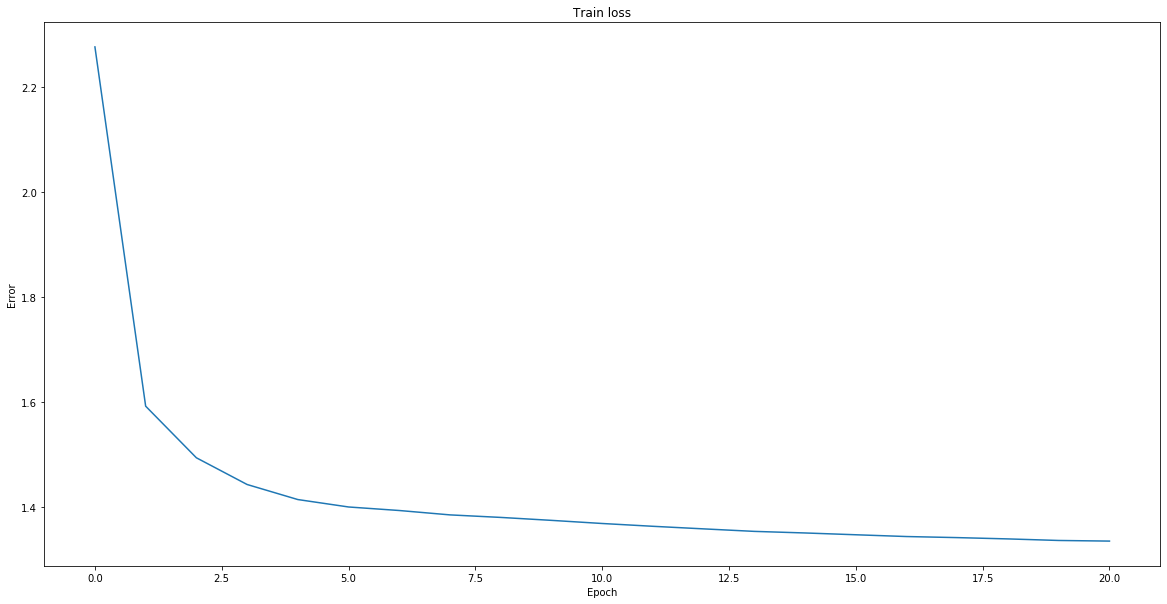

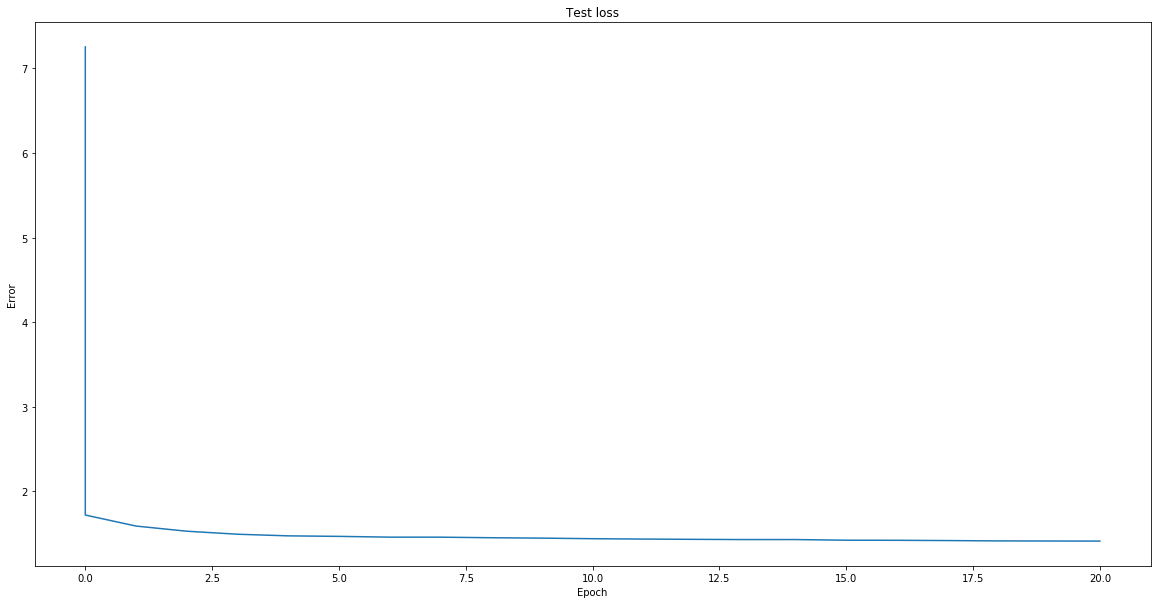

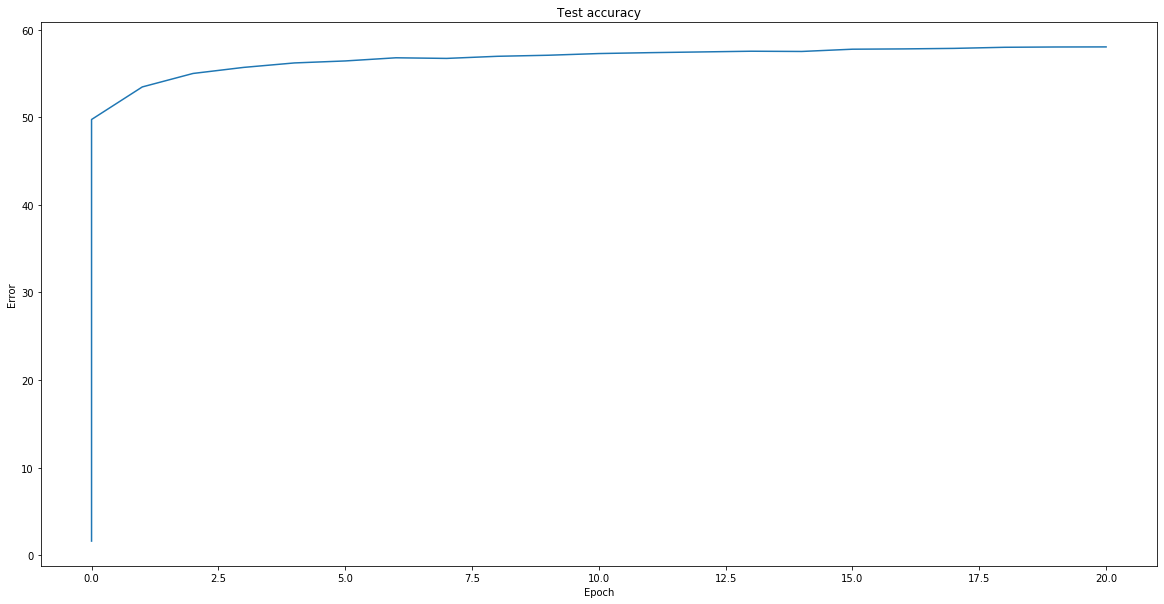

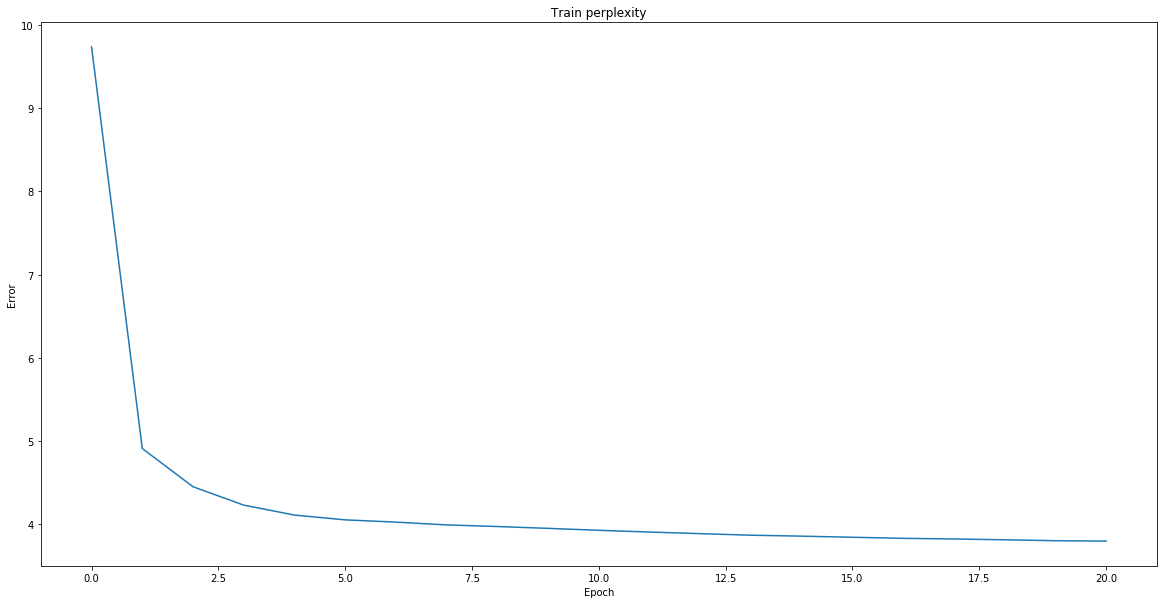

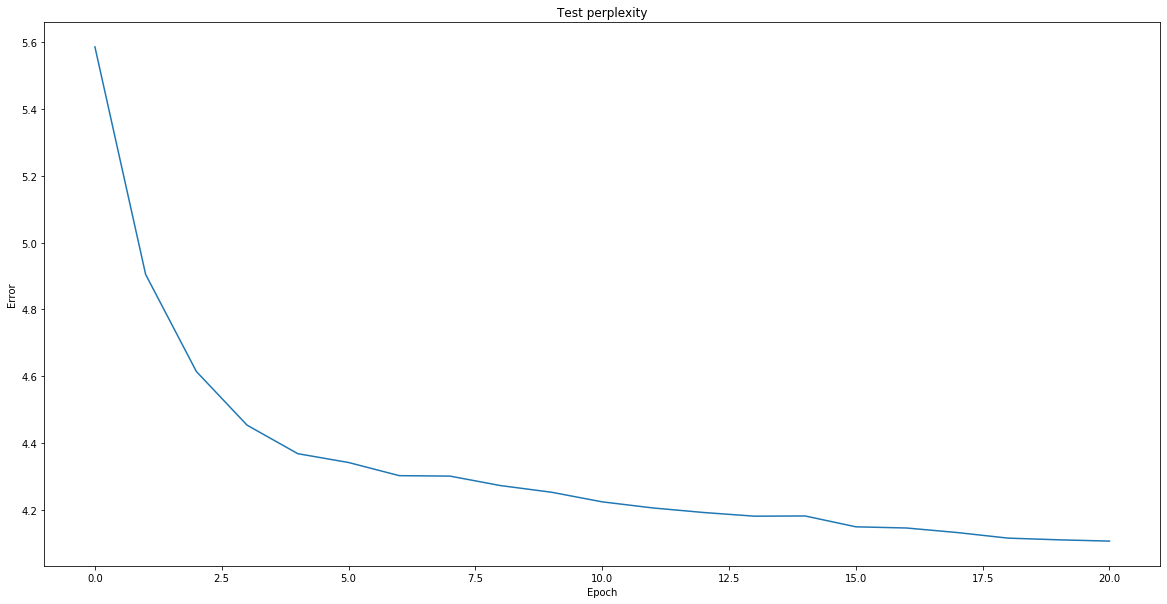

In [12]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')

    train_losses, test_losses, test_accuracies,train_ppls,test_ppls = pt_util.read_log(LOG_PATH, ([], [], [],[],[]))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            train_ppl = math.exp(train_loss)
            test_loss, test_accuracy = test(model, device, test_loader)
            test_ppl = math.exp(test_loss)
            train_ppls.append((epoch,train_ppl))
            test_ppls.append((epoch, test_ppl))
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies,train_ppls, test_ppls))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
    
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            #generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            #print('generated max\t\t', generated_sentence)
            #for ii in range(10):
                #generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                #print('generated sample\t', generated_sentence)
            #generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            #print('generated beam\t\t', generated_sentence)
            #print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        ep, val = zip(*train_ppls)
        pt_util.plot(ep, val, 'Train perplexity', 'Epoch', 'Error')
        ep, val = zip(*test_ppls)
        pt_util.plot(ep, val, 'Test perplexity', 'Epoch', 'Error')
        return model, vocab, device

final_model, vocab, device = main()

#Part 7: Experiments

In [0]:
def eval_final_model(model, vocab, device):
    seed_words = 'His blue eyes were light, bright, and sparkling behind'
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(3):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(3):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 His blue eyes were light, bright, and sparkling behind the corridor and the stand and started and the stand and started and the stand and started and the stand and started and the stand and started and the stand and started and the stand and started and 
generated with sample	 His blue eyes were light, bright, and sparkling behind a for around another, sin%ing. Tunning Quffusture can't I" "Yearly SleckeD? you knee, and, and dadn' gobby don't be got anxkeves?" She say know, was gold glassed around the mage bed over the late Bla
generated with sample	 His blue eyes were light, bright, and sparkling behind its plint round away, from the enough Goody wand at to ~profele, they missed appoints. The finby our of SNED!I)EDET SYEUB?K !"S is fortstand. The kill storuz3be or that Blaston: He saw on the feed to
generated with sample	 His blue eyes were light, bright, and sparkling behindveshird. but know.." Sorned, is there doing." "Yes, jum murds?" BiAng comn! Malfoy was Colfi

#Part 8: Other things
Choose **three** of the following to try. You should create new code cells below rather than modifying your earlier code:


1. Train on a different text corpus. The corpus should be at least as large as the provided Harry Potter dataset.
    - Options include other books, websites, tweets, wikipedia articles etc.
    -  (Hint: this is probably the easiest one)
1. Find a better network architecture. Some ideas:
    - Look at the various options in https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    - You can make the network wider or deeper.
    - You can try to learn separate encoders and decoders.
1. Use an LSTM instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM
    - The output of an LSTM is a hidden state **and** a cell state, so you will need to deal with a tuple instead of a single vector.
1. Use a Transformer instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer
    - Be sure to get the masks right so you don't condition on the future characters: https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer.generate_square_subsequent_mask may be of use.
1. Train a model using student-forcing.
    - You will have to modify the network inputs.
    - You will need to use `torch.nn.GRUCell` and its like. https://pytorch.org/docs/stable/nn.html#grucell
    - You cannot simply feed an empty string to start off a sequence. The sequence must be somehow conditioned on prior ground truth.
1. Train a model on words instead of characters.
    - You will need to redefine your input/output space vocabulary as well.
    - You should replace any words that occur less than 5 times in the dataset with an <unknown\> token. 
1. Write a new data loader which picks a random point in the text to start from and returns 10 consecutive sequences starting from that point onward. 
    - You should also modify the train and test functions to reset the memory when you reset the sequence.
    - You should consider an epoch to be feeding in approximately the number of characters in the dataset.
    - You may run into issues if your dataset size/epochs are not a multiple of your batch size.
1. Train on sentences instead of one long sequence.
    - You should still produce output character by character.
    - Sentences can end with a . ! ?, but words like Mr. generally do not end a sentence.
    - A sentence may also continue in the case of quotations. For example: ``"Do your homework!" said the TAs.`` is only one sentence.
    - Your parsing does not have to be perfect, but try to incorporate as many of these rules as you can.
    - Feel free to use existing NLP tools for finding sentence endings. One is spacy: https://spacy.io/usage/linguistic-features#section-sbd
    - All sentences should end with an <eos\> token. Your output sampling should now stop when it produces the <eos\> token.



#Part 9: Short answer questions
Please answer these questions, and put the answers in a file called short_answer.pdf in your repository.


1. Just like last time, provide plots for training error, test error, and test accuracy. Also provide a plot of your train and test perplexity per epoch.
    - In class we defined perplexity as `2^(p*log_2(q))`, However the PyTorch cross entropy function uses the natural log. To compute perplexity directly from the cross entropy, you should use `e^p*ln(q)`.
    - We encourage you to try multiple network modifications and hyperparameters, but you only need to provide plots for your best model. Please list the modifications and hyperparameters.    
    
2. What was your final test accuracy? What was your final test perplexity?
3. What was your favorite sentence generated via each of the sampling methods? What was the prompt you gave to generate that sentence?
4. Which sampling method seemed to generate the best results? Why do you think that is?
5. For sampling and beam search, try multiple temperatures between 0 and 2. 
    - Which produces the best outputs? Best as in made the most sense, your favorite, or funniest, doesn't really matter how you decide.
    - What does a temperature of 0 do? What does a temperature of 0<temp<1 do? What does a temperature of 1 do? What does a temperature of above 1 do? What would a negative temperature do (assuming the code allowed for negative temperature)?
    
Questions for each of the "Other things" sections. Only answer the questions corresponding to the ones you chose.

1. New Corpus
    1. What corpus did you choose? How many characters were in it?
    2. What differences did you notice between the sentences generated with the new/vs old corpus.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. New Architecture
    1. What was your design? What did you try that didn't work well?
    2. What was your lowest test perplexity? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. LSTM
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. Transformer
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).
    
1. Student-forcing
    1. What new difficulties did you run into while training?
    2. Were the results better than with teacher-forcing?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was).
    
1. Words
    1. What new difficulties did you run into while training?
    2. How large was your vocabulary?
    3. Did you find that different batch size, sequence length, and feature size and other hyperparameters were needed? If so, what worked best for you?

1. Random Dataloader
    1. What new difficulties did you run into while training?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 
    
1. Sentences
    1. What new difficulties did you run into while training? What new difficulties did you run into while preprocessing?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 


    